In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

## Table of Contents

* **[Database creation](#Database-creation)**
* **[ETL](#ETL)**
* **[Downloading data from the database](#Downloading-data-from-the-database)**
* **[Handling NaN's and changing data types](#Handling-NaN's-and-changing-data-types)**
* **[RFM segmentation](#RFM-segmentation)**
  * [Elbow method](#Elbow-method)
  * [K-Means](#K-Means)
* **[Exploratory data analysis](#Exploratory-data-analysis)**
  * [Tenure check](#Tenure-check)
  * [Customers by gender and location, MAU](#Customers-by-gender-and-location,-MAU)
  * [Customer acquisition by month, CAC](#Customer-acquisition-by-month,-CAC)
  * [Cohort analysis - retention and total revenue](#Cohort-analysis---retention-and-total-revenue)
  * [Revenue and profit analysis, ARPU](#Revenue-and-profit-analysis,-ARPU)
  * [Number of orders, AOV](#Number-of-orders,-AOV)
  * [Products, categories, and discounts analysis](#Products,-categories,-and-discounts-analysis)
  * [Summary](#Summary)
* **[Churn prediction - survival analysis](#Churn-prediction---survival-analysis)**
* **[LTV prediction - BG/NBD and Gamma-Gamma](#LTV-prediction---BG/NBD-and-Gamma-Gamma)**
  * [Comparing Gamma-Gamma method to tenure method](#Comparing-Gamma-Gamma-method-to-tenure-method)
  
Data was [downloaded from Kaggle](https://www.kaggle.com/datasets/rishikumarrajvansh/marketing-insights-for-e-commerce-company/data)

## Database creation

This is the first step where I create the database and tables for the data from Kaggle.

The **ETL pipeline** (downloading the data from Kaggle, 
transforming it so that it fully corresponds with the tables,
and loading the data into to tables) **is in the additional .py files**.


In [2]:
# Connection parameters
params = {
    'host': 'localhost',
    'user': 'postgres',
    'password': '1234',
    'port': 5432
}

# Connecting to PostgreSQL server
try:
    conn = psycopg2.connect(**params)
    conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
    print('Connected')
except:
    print('Could not connect')

# Creating a cursor
cur = conn.cursor()

# Creating the 'marketing_data' database
db_name = 'marketing_data'
try:
    cur.execute(f'CREATE DATABASE {db_name}')
    print(f'Database {db_name} was created')
except:
    print(f'Database {db_name} was not created')

# Closing connection to the default database
try:
    cur.close()
    conn.close()
    print('Connection closed')
except:
    print('Connection was not closed')


Connected
Database marketing_data was created
Connection closed


In [3]:
# Connecting to the newly created database
params['dbname'] = db_name
conn = psycopg2.connect(**params)

# Creating a cursor for the new connection
cur = conn.cursor()

# SQL statements to create tables with relations
create_tables_queries = [
    ('customers', 
     '''
     drop table if exists customers cascade;
    CREATE TABLE customers (
        customer_id VARCHAR(255) PRIMARY KEY,
        gender VARCHAR(50) NOT NULL,
        location TEXT NOT NULL,
        tenure_months INT NOT NULL
    )'''),
    ('category_taxes', 
     '''
     drop table if exists category_taxes cascade;
    CREATE TABLE category_taxes (
        category_id SERIAL PRIMARY KEY,
        product_category VARCHAR(255) NOT NULL,
        gst NUMERIC NOT NULL
    )'''),
    ('products', 
     '''
     drop table if exists products cascade;
    CREATE TABLE products (
        product_sku VARCHAR(255) PRIMARY KEY,
        product_description TEXT NOT NULL,
        category_id INT NOT NULL,        
        FOREIGN KEY (category_id) REFERENCES category_taxes(category_id)
    )'''),
    ('product_prices', 
     '''
     drop table if exists product_prices cascade;
    CREATE TABLE product_prices (
        price_id SERIAL PRIMARY KEY,
        product_sku VARCHAR(255) NOT NULL,
        date DATE NOT NULL,       
        price NUMERIC NOT NULL,
        FOREIGN KEY (product_sku) REFERENCES products(product_sku)
    )'''),
    ('discounts', 
     '''
     drop table if exists discounts cascade;
    CREATE TABLE discounts (
        discount_id NUMERIC PRIMARY KEY,
        month INT NOT NULL,
        category_id INT NOT NULL,
        coupon_code VARCHAR(255) NOT NULL,
        discount_pct NUMERIC NOT NULL,
        FOREIGN KEY (category_id) REFERENCES category_taxes(category_id)
    )'''),
    ('marketing_spends', 
     '''
     drop table if exists marketing_spends cascade;
    CREATE TABLE marketing_spends (
        spend_id SERIAL PRIMARY KEY,
        date DATE NOT NULL,
        offline_spend NUMERIC NOT NULL,
        online_spend NUMERIC NOT NULL
    )'''),
    ('transactions', 
     '''
     drop table if exists transactions cascade;
    CREATE TABLE transactions (
        transaction_id VARCHAR(255) PRIMARY KEY,
        transaction_date DATE NOT NULL,
        customer_id VARCHAR(255) NOT NULL,
        delivery_charges NUMERIC NOT NULL,
        FOREIGN KEY (customer_id) REFERENCES customers(customer_id)
    )'''),
    ('product_transactions', 
     '''
     drop table if exists product_transactions cascade;
    CREATE TABLE product_transactions (
        product_transaction_id SERIAL PRIMARY KEY,
        transaction_id VARCHAR(255) NOT NULL,
        product_sku VARCHAR(255) NOT NULL,
        price_id INT NOT NULL,
        quantity INT NOT NULL,
        discount_id NUMERIC NULL,
        coupon_status VARCHAR(255) NOT NULL,
        FOREIGN KEY (transaction_id) REFERENCES transactions(transaction_id),
        FOREIGN KEY (product_sku) REFERENCES products(product_sku),
        FOREIGN KEY (price_id) REFERENCES product_prices(price_id),
        FOREIGN KEY (discount_id) REFERENCES discounts(discount_id)
    )''')
]

# Executing each table creation command
for q_id, (table_name, query) in enumerate(create_tables_queries, start=1):
    try:
        cur.execute(query)
        print(f'Query {q_id} done. Table "{table_name}" was created.')
    except Exception as e:
        print(f'Query {q_id} failed. Table "{table_name}" was not created. Error: {e}')

# Closing connection with the database
conn.commit()
cur.close()
conn.close()

Query 1 done. Table "customers" was created.
Query 2 done. Table "category_taxes" was created.
Query 3 done. Table "products" was created.
Query 4 done. Table "product_prices" was created.
Query 5 done. Table "discounts" was created.
Query 6 done. Table "marketing_spends" was created.
Query 7 done. Table "transactions" was created.
Query 8 done. Table "product_transactions" was created.


## ETL

This step's code can be found in the **etl_functions.py** and **marketing_data_dag.py** files.

During this step the ETL pipeline Airflow DAG was run and the data was extracted, transformed, and loaded into the database.

Here is a graph of the ETL pipeline:

<img src="images/dag_graph.png" />


## Downloading data from the database

Firstly, we need to get the data from the database and pre-process it to make it easier to work on.

In [4]:
# Downloading data from each table of the database

params = {
    'host': 'localhost',
    'user': 'postgres',
    'password': '1234',
    'port': 5432,
    'dbname': 'marketing_data'
}

conn = psycopg2.connect(**params)
cur = conn.cursor()

database_tables = ['marketing_spends',
                   'customers',
                   'category_taxes',
                   'products',
                   'product_prices',
                   'discounts',
                   'transactions',
                   'product_transactions'
                  ]

dataframes_from_database = {}
for table in database_tables:
    
    query = f'select * from {table}'
    
    cur.execute(query)
    rows = cur.fetchall()
    column_names = [desc[0] for desc in cur.description]
    
    df = pd.DataFrame(rows, columns=column_names)
    dataframes_from_database[table] = df

# Closing cursor and connection
cur.close()
conn.close()

# dataframes_from_database

In [5]:
# Creating a single dataframe with all sales data
sales = (
    dataframes_from_database['product_transactions']
    .merge(dataframes_from_database['transactions'], 
           on='transaction_id', 
           how='left')
    .merge(dataframes_from_database['product_prices'][['price_id', 'price']], 
           on='price_id', 
           how='left')
    .merge(dataframes_from_database['products'][['product_sku','product_description','category_id']], 
           on='product_sku', 
           how='left')
    .merge(dataframes_from_database['category_taxes'], 
           on='category_id', 
           how='left')
    .merge(dataframes_from_database['discounts'][['discount_id','coupon_code','discount_pct']], 
           on='discount_id', 
           how='left')
    .merge(dataframes_from_database['customers'], 
           on='customer_id', 
           how='left')
)

# Creating a separate dataframe with marketing spends
marketing_spends = dataframes_from_database['marketing_spends']

sales.head()

,product_transaction_id,transaction_id,product_sku,price_id,quantity,discount_id,coupon_status,transaction_date,customer_id,delivery_charges,price,product_description,category_id,product_category,gst,coupon_code,discount_pct,gender,location,tenure_months
0,1,16679,GGOENEBJ079499,47,1,4.0,Used,2019-01-01,17850,6.5,153.71,Nest Learning Thermostat 3rd Gen-USA - Stainle...,1,Nest-USA,0.1,ELEC10,10,M,Chicago,12
1,2,16680,GGOENEBJ079499,47,1,4.0,Used,2019-01-01,17850,6.5,153.71,Nest Learning Thermostat 3rd Gen-USA - Stainle...,1,Nest-USA,0.1,ELEC10,10,M,Chicago,12
2,3,16681,GGOEGFKQ020399,31,1,7.0,Used,2019-01-01,17850,6.5,2.05,Google Laptop and Cell Phone Stickers,2,Office,0.1,OFF10,10,M,Chicago,12
3,4,16682,GGOEGAAB010516,4,5,1.0,Not Used,2019-01-01,17850,6.5,17.53,Google Men's 100% Cotton Short Sleeve Hero Tee...,3,Apparel,0.18,SALE10,10,M,Chicago,12
4,5,16682,GGOEGBJL013999,22,1,16.0,Used,2019-01-01,17850,6.5,16.5,Google Canvas Tote Natural/Navy,4,Bags,0.18,AIO10,10,M,Chicago,12


## Handling NaN's and changing data types

Let's start by checking the data for NaNs and understanding the data types:

In [6]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53673 entries, 0 to 53672
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   product_transaction_id  53673 non-null  int64 
 1   transaction_id          53673 non-null  object
 2   product_sku             53673 non-null  object
 3   price_id                53673 non-null  int64 
 4   quantity                53673 non-null  int64 
 5   discount_id             53273 non-null  object
 6   coupon_status           53673 non-null  object
 7   transaction_date        53673 non-null  object
 8   customer_id             53673 non-null  object
 9   delivery_charges        53673 non-null  object
 10  price                   53673 non-null  object
 11  product_description     53673 non-null  object
 12  category_id             53673 non-null  int64 
 13  product_category        53673 non-null  object
 14  gst                     53673 non-null  object
 15  co

**There are 400 rows where coupon_code, discount_pct, and discount_id are NaN, 
which means that some of the transactions did not have any corresponding discount_ids**.

Let's fill these NaNs with zeros and 'No coupon'.

Let's also change some of the data types

In [7]:
# Handling NaNs
sales['discount_id'].fillna(0, inplace=True) 
sales['coupon_code'].fillna('No coupon', inplace=True) 
sales['discount_pct'].fillna(0, inplace=True)

# Changing data types
sales['transaction_date'] = pd.to_datetime(sales['transaction_date'])
sales['price'] = sales['price'].astype('float')
sales['gst'] = sales['gst'].astype('float')
sales['discount_pct'] = sales['discount_pct'].astype('float')
sales['delivery_charges'] = sales['delivery_charges'].astype('float')

marketing_spends['date'] = pd.to_datetime(marketing_spends['date'])
marketing_spends['online_spend'] = marketing_spends['online_spend'].astype('float')
marketing_spends['offline_spend'] = marketing_spends['offline_spend'].astype('float')

# Checking that there are no NaNs
sales.isna().sum()

product_transaction_id    0
transaction_id            0
product_sku               0
price_id                  0
quantity                  0
discount_id               0
coupon_status             0
transaction_date          0
customer_id               0
delivery_charges          0
price                     0
product_description       0
category_id               0
product_category          0
gst                       0
coupon_code               0
discount_pct              0
gender                    0
location                  0
tenure_months             0
dtype: int64

## RFM segmentation

Before continuing EDA, I want to conduct the customers' segmentation using RFM (recency, frequency, and monetary) method.

By doing this, I'll get an ability to research the differences in customers' behavior better.

Also, I need to calculate the revenue the ecommerce company gets from each transaction:


In [8]:
# Calculating revenue from each transaction
# revenue = ((quantity * price) * (1 - discount_pct / 100) * (1 + gst)) + delivery_charges
sales['revenue'] = ((sales['quantity'] * sales['price']) * (1 - np.where(sales['coupon_status'] == 'Used', sales['discount_pct'] / 100, 0)) * (1 + sales['gst'])) + sales['delivery_charges']

# RFM segmentation
today_date = sales['transaction_date'].max() + timedelta(days=1)

# Calculating "recency", "frequency", and "monetary" for each customer
rfm = sales.groupby('customer_id', as_index=False).agg({
    'transaction_date': lambda x:((today_date - x.max())).days,
    'transaction_id': 'nunique',
    'revenue': 'sum'
}).rename(columns={
    'transaction_date': 'recency',
    'transaction_id': 'frequency',
    'revenue': 'monetary'
})

rfm.head()


,customer_id,recency,frequency,monetary
0,12347,60,31,15734.79612
1,12348,74,7,1298.00972
2,12350,18,11,1906.38928
3,12356,108,12,1991.72226
4,12359,131,2,1015.22640


In [9]:
# Standardization of recency, frequency, and monetary
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Defining the dataframe and columns I'll work with
feature_columns = ['recency','frequency','monetary']
standardized_rfm = rfm.copy()

# Scaling
standardized_columns = scaler.fit_transform(standardized_rfm[feature_columns])
standardized_rfm[feature_columns] = standardized_columns

standardized_rfm.head()

,customer_id,recency,frequency,monetary
0,12347,-0.830351,0.527086,1.883202
1,12348,-0.694028,-0.451150,-0.424683
2,12350,-1.239321,-0.288111,-0.327426
3,12356,-0.362957,-0.247351,-0.313785
4,12359,-0.138998,-0.654949,-0.469889


### Elbow method

Although in the dataset description 4 customer segments were suggested (standard, silver, gold, and premium),
I want to use the KMeans with "elbow" method first to see what number of clusters (= number of segments) is the most optimal.

Let's fit the KMeans and plot the SSE (Sum of Squared Errors):

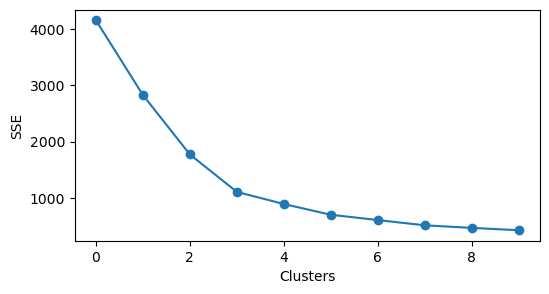

In [10]:
from sklearn.cluster import KMeans

sse = []

for i in np.arange(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(standardized_rfm[feature_columns])
    sse.append(kmeans.inertia_)


plt.figure(figsize=(6,3))
plt.plot(sse, marker='o')
plt.xlabel('Clusters')
plt.ylabel('SSE');


According to this plot, **the optimal number of clusters is 3**.

**However, let's use the suggested number of clusters = 4 for now**:

### K-Means

In [11]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(standardized_rfm[feature_columns])
rfm['cluster'] = (kmeans.labels_ + 1)

rfm

,customer_id,recency,frequency,monetary,cluster
0,12347,60,31,15734.79612,1
1,12348,74,7,1298.00972,2
2,12350,18,11,1906.38928,2
3,12356,108,12,1991.72226,2
4,12359,131,2,1015.22640,2
...,...,...,...,...,...
1382,18250,19,6,3245.06770,2
1383,18256,180,2,83.35360,4
1384,18259,271,1,46.01640,4
1385,18260,88,15,2397.04688,2


In [12]:
rfm_grouped = rfm.groupby('cluster', as_index=False)[['recency','frequency','monetary']].mean()
rfm_grouped

,cluster,recency,frequency,monetary
0,1,83.736842,57.894737,13484.430427
1,2,77.420680,13.270538,2739.213430
2,3,30.200000,276.800000,73908.223944
3,4,255.645038,10.511450,2160.193855


Now we can see that the **elbow method suggested to divide the customers into just 3 segments: 
"standard", "silver", and "gold"**.

But the **dataset author suggested to select one more "premium" segment inside the "gold" one**.

**This "premium" segment differs a lot from all other segments - its customers are the most frequent users who pay the most**.

Now let's assign segment names according to cluster numbers:

In [13]:
# Ranking the clusters based on recency, frequency, and monetary
rfm_grouped['recency_rank'] = rfm_grouped['recency'].rank(ascending=True)
rfm_grouped['frequency_rank'] = rfm_grouped['frequency'].rank(ascending=False)
rfm_grouped['monetary_rank'] = rfm_grouped['monetary'].rank(ascending=False)
rfm_grouped['total_rank'] = rfm_grouped[['recency_rank','frequency_rank','monetary_rank']].sum(axis=1)

# Assigning segments based on rankings
def assign_group(row, sorted_ranks):
    if row['total_rank'] == sorted_ranks[0]:
        return 'premium'
    elif row['total_rank'] == sorted_ranks[1]:
        return 'gold'
    elif row['total_rank'] == sorted_ranks[2]:
        return 'silver'
    elif row['total_rank'] == sorted_ranks[3]:
        return 'standard'

# Sorting the total ranks
sorted_ranks = sorted(rfm_grouped['total_rank'].unique())

# Apply the function with sorted ranks as argument
rfm_grouped['segment'] = rfm_grouped.apply(assign_group, args=(sorted_ranks,), axis=1)

# Merge the group information back to the original DataFrame
rfm = pd.merge(rfm, rfm_grouped[['cluster', 'segment']], on='cluster', how='left')
rfm.head()


,customer_id,recency,frequency,monetary,cluster,segment
0,12347,60,31,15734.79612,1,gold
1,12348,74,7,1298.00972,2,silver
2,12350,18,11,1906.38928,2,silver
3,12356,108,12,1991.72226,2,silver
4,12359,131,2,1015.22640,2,silver


silver      706
standard    524
gold        152
premium       5
Name: segment, dtype: int64


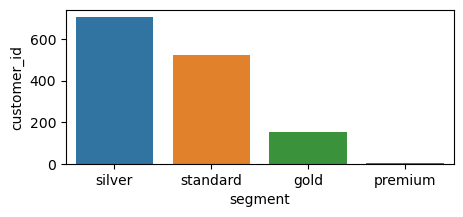

In [14]:
# Plotting the distribution of segments
plt.figure(figsize=(5,2))
sns.barplot(
    data=rfm.groupby('segment', as_index=False)['customer_id'].nunique().sort_values('customer_id', ascending=False), 
    x='segment', 
    y='customer_id');

print(rfm['segment'].value_counts())

Looks like there are just 5 "premium" customers who pay us the most.

Let's join the newly formed segments to the main dataframe:

In [15]:
sales = sales.merge(
    rfm[['customer_id','segment']],
    how='left',
    on='customer_id'
)
sales


,product_transaction_id,transaction_id,product_sku,price_id,quantity,discount_id,coupon_status,transaction_date,customer_id,delivery_charges,...,category_id,product_category,gst,coupon_code,discount_pct,gender,location,tenure_months,revenue,segment
0,1,16679,GGOENEBJ079499,47,1,4.0,Used,2019-01-01,17850,6.50,...,1,Nest-USA,0.10,ELEC10,10.0,M,Chicago,12,158.67290,gold
1,2,16680,GGOENEBJ079499,47,1,4.0,Used,2019-01-01,17850,6.50,...,1,Nest-USA,0.10,ELEC10,10.0,M,Chicago,12,158.67290,gold
2,3,16681,GGOEGFKQ020399,31,1,7.0,Used,2019-01-01,17850,6.50,...,2,Office,0.10,OFF10,10.0,M,Chicago,12,8.52950,gold
3,4,16682,GGOEGAAB010516,4,5,1.0,Not Used,2019-01-01,17850,6.50,...,3,Apparel,0.18,SALE10,10.0,M,Chicago,12,109.92700,gold
4,5,16682,GGOEGBJL013999,22,1,16.0,Used,2019-01-01,17850,6.50,...,4,Bags,0.18,AIO10,10.0,M,Chicago,12,24.02300,gold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53668,53669,48493,GGOENEBB078899,6772,1,159.0,Clicked,2019-12-31,14410,6.50,...,1,Nest-USA,0.10,ELEC30,30.0,F,New York,45,139.93000,silver
53669,53670,48494,GGOEGAEB091117,6761,1,156.0,Used,2019-12-31,14410,6.50,...,3,Apparel,0.18,SALE30,30.0,F,New York,45,46.90792,silver
53670,53671,48495,GGOENEBQ084699,6778,1,159.0,Used,2019-12-31,14410,6.50,...,1,Nest-USA,0.10,ELEC30,30.0,F,New York,45,123.44760,silver
53671,53672,48496,GGOENEBQ079199,6777,5,159.0,Clicked,2019-12-31,14600,6.50,...,1,Nest-USA,0.10,ELEC30,30.0,F,California,7,449.36000,silver


## Exploratory data analysis

Now, we can continue with the EDA and already use the customer segments.

Let's start by checking the minimum and maximum dates of both transactions and marketing spends:

In [16]:
print(f'''
min transaction date = {sales['transaction_date'].dt.date.min()}
max transaction date = {sales['transaction_date'].dt.date.max()}
---------------------------------
min marketing spends date = {marketing_spends['date'].dt.date.min()}
max marketing spends date = {marketing_spends['date'].dt.date.max()}
''')


min transaction date = 2019-01-01
max transaction date = 2019-12-31
---------------------------------
min marketing spends date = 2019-01-01
max marketing spends date = 2019-12-31



Okay, **we have the data for the full 2019**.
Now let's also check the **main statistics of int/float columns**:

In [17]:
sales[['quantity','price','delivery_charges','gst','discount_pct','tenure_months']].describe()

,quantity,price,delivery_charges,gst,discount_pct,tenure_months
count,53673.000000,53673.000000,53673.000000,53673.000000,53673.000000,53673.000000
mean,4.612915,51.354517,10.665404,0.136241,19.784622,26.116968
std,20.603397,63.418353,20.038417,0.046646,8.271269,13.447914
min,1.000000,0.400000,0.000000,0.050000,0.000000,2.000000
25%,1.000000,5.590000,6.000000,0.100000,10.000000,15.000000
50%,1.000000,16.790000,6.000000,0.180000,20.000000,27.000000
75%,2.000000,100.910000,6.500000,0.180000,30.000000,37.000000
max,900.000000,355.740000,521.360000,0.180000,30.000000,50.000000


**Insights:**
- **on average customers order just 4 pieces**, but someone ordered **900** pieces!
- **average delivery costs just 10**, but for some transaction it cost **>500**!
- **minimum tenure is 2 months and not zero**, which looks totally illogical,
    as **it means all customers in the data are "old"**.
    
    At the same time, on Kaggle page is was suggested by the author of the dataset to **analyse the relation
    between marketing spends and customers' acquisition, but we only have marketing_spends data for 2019**.
    
    We certainly need to address the tenure problem.
    
### Tenure check

To do that, let's print **the customers with their minimum and maximum transaction_dates and their tenure_months**:


In [18]:
tenure_check = sales.groupby(['customer_id','tenure_months'], as_index=False).agg({'transaction_date':['min','max']})
tenure_check.columns = ['customer_id', 'tenure_months', 'transaction_date_min', 'transaction_date_max']
tenure_check.sort_values(['tenure_months','transaction_date_min']).head()

,customer_id,tenure_months,transaction_date_min,transaction_date_max
32,12472,2,2019-01-11,2019-10-30
966,16539,2,2019-01-13,2019-06-20
791,15716,2,2019-02-16,2019-02-17
1243,17674,2,2019-03-04,2019-03-04
257,13329,2,2019-03-27,2019-07-08


As I said earlier, **this looks very illogical**.

**For example, for customer 13329 tenure_months = 2 and minimum transaction_date = '2019-03-27'**:
- If tenure_months = number of months between the acquisition date and the most recent transaction,
    it is incorrect, as even if we use transaction_date_min as the acquisition date, 
    (transaction_date_max - transaction_date_min) > 2
- At the same time, if tenure_months = number of months before '2019-01-01',
    it is also incorrect, as with this logic there are no customers acquired in 2019 at all

**As I'm going to use tenure in the churn and LTV prediction, I'm going to recalculate tenure_months differently:**
- I will use the **minimum transaction_date as the acquisition date**,
- The **tenure = churn date - minimum transaction_date**,
    where **churn_date will be calculated according to the frequency of purchases**:
    
    - For example, if a person **did not have any purchases for 3 months after the last purchase,
        he/she is considered churned**, and we can use his/her **last transaction date as churn date**
    - At the same time, if a person **had his/her last transaction 2 months ago (and now is '2020-01-01'),
        we can use the "today" date as the churn date**.
        
    * This is just an example of logic, which I will perform and describe later

### Customers by gender and location, MAU

Now let's plot the distributions of customers by their gender and location:


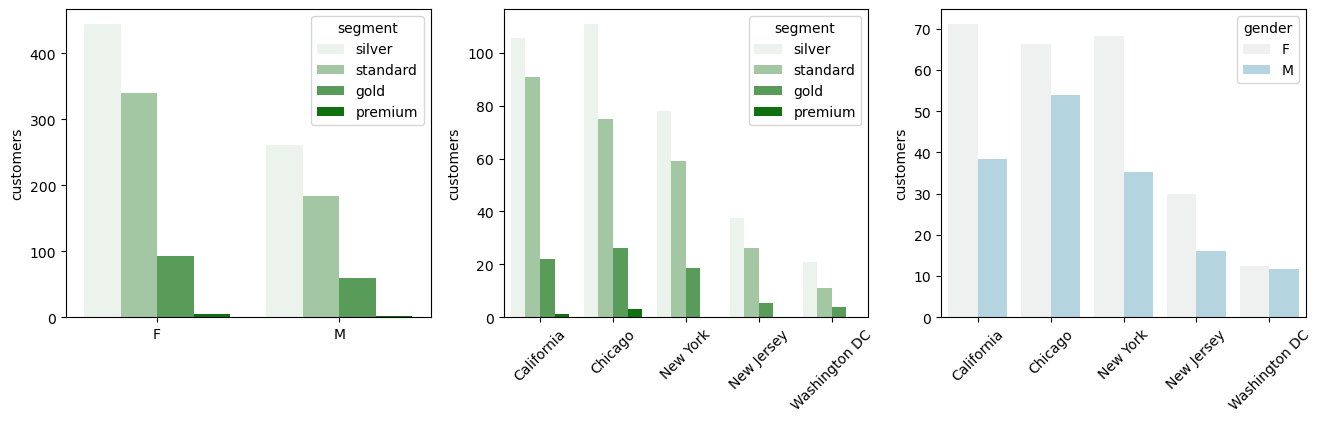

In [19]:
# By gender
customers_per_gender = sales.groupby(['gender','segment'], as_index=False)['customer_id'].nunique() \
    .sort_values('customer_id', ascending=False)

# By location
customers_per_location = sales.groupby(['location','segment','gender'], as_index=False)['customer_id'].nunique() \
    .sort_values('customer_id', ascending=False)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(16,4))
ax1 = sns.barplot(data=customers_per_gender, x='gender', y='customer_id', color='green', ax=axs[0], hue='segment')
ax1.set(xlabel='', ylabel='customers')

ax2 = sns.barplot(data=customers_per_location, x='location', y='customer_id', color='green', ax=axs[1], hue='segment', ci=False)
ax2.set(xlabel='', ylabel='customers')
ax2.tick_params('x', labelrotation=45)

ax3 = sns.barplot(data=customers_per_location, x='location', y='customer_id', color='lightblue', ax=axs[2], hue='gender', ci=False)
ax3.set(xlabel='', ylabel='customers')
ax3.tick_params('x', labelrotation=45);


- **There are more females among our customers than males in total**
- **Males and females are almost equally distributed in different segments**
- **In Chicago and Washington DC the number of females is higher than the number of males, 
    but not as much as in other locations**
- **There are more "silver", "gold", and "premium" customers overall in Chicago than in any other location**

Now let's analyse MAU (unique users who purchased in the store during a month):


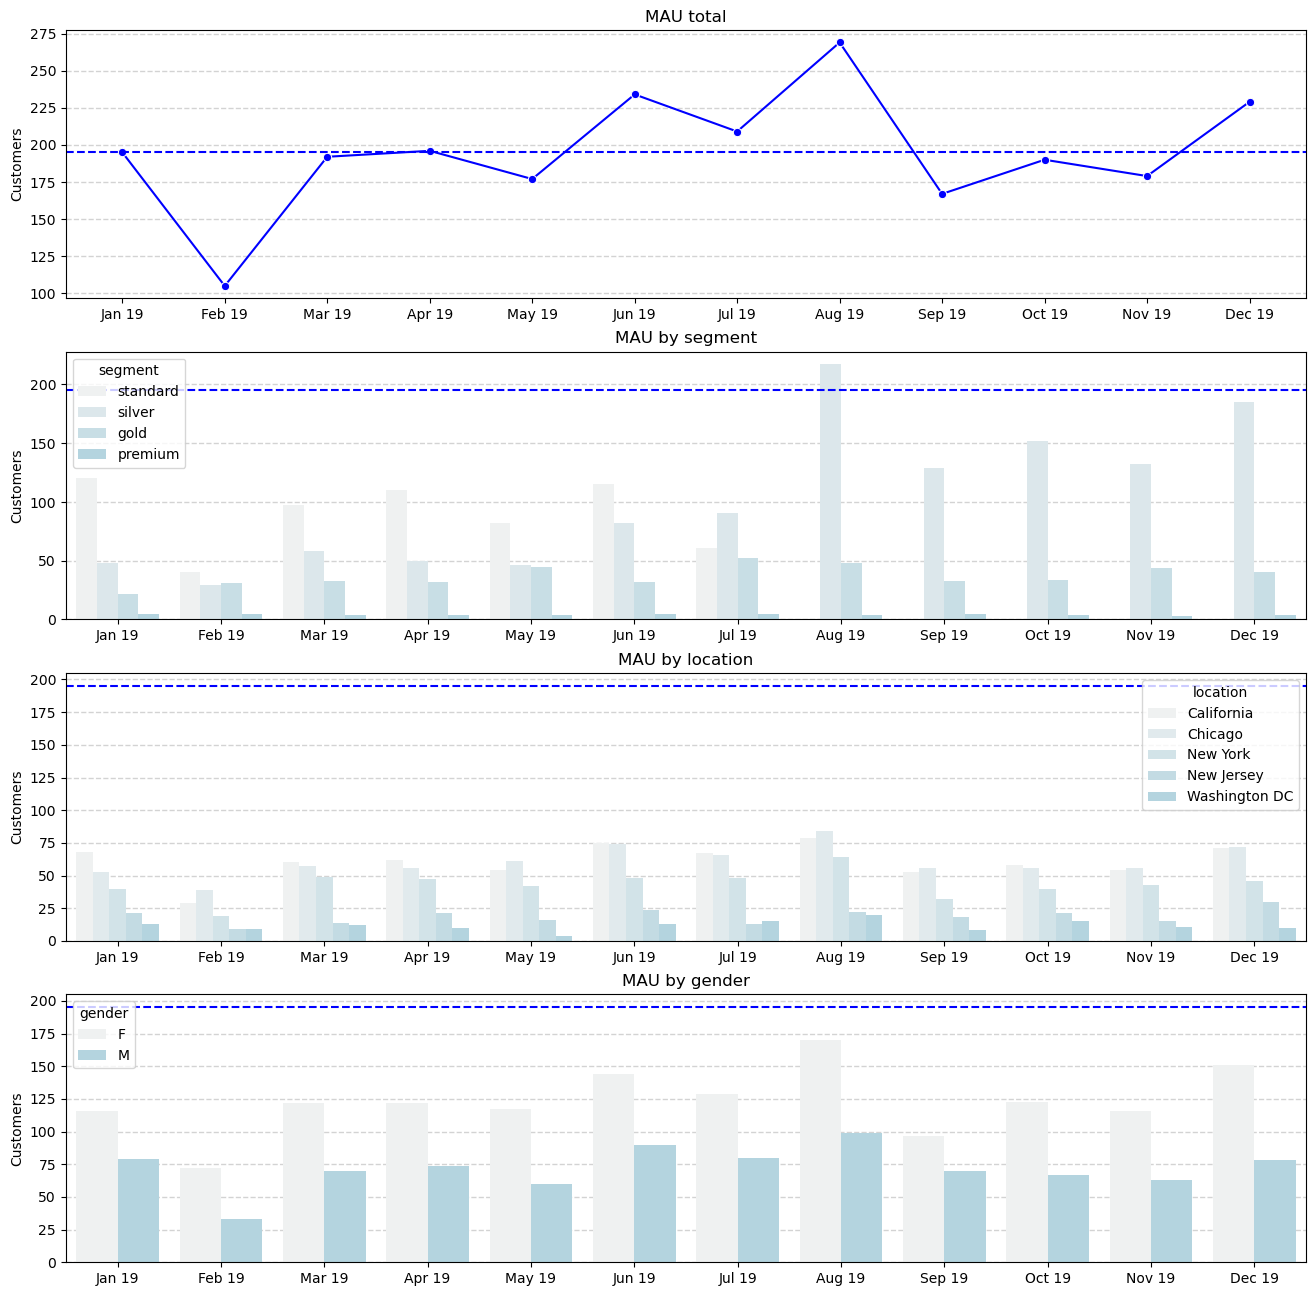

In [20]:
# Unique customers by month (MAU)
# Truncating dates to month
sales['transaction_month'] = sales['transaction_date'].dt.to_period('M').dt.to_timestamp()

# Format dates like 'Jan 19'
sales['transaction_month_name'] = sales['transaction_date'].dt.strftime('%b %y')

# Total
mau_total =  sales.groupby(['transaction_month','transaction_month_name'], as_index=False)['customer_id'].nunique() \
    .sort_values(['transaction_month','customer_id'], ascending=[True, False])

avg_unique_customers_per_month = mau_total['customer_id'].mean()


# Segment
mau_segment = sales.groupby(['transaction_month','transaction_month_name','segment'], as_index=False)['customer_id'].nunique() \
    .sort_values(['transaction_month','customer_id'], ascending=[True, False])

# Location
mau_location = sales.groupby(['transaction_month','transaction_month_name','location'], as_index=False)['customer_id'].nunique() \
    .sort_values(['transaction_month','customer_id'], ascending=[True, False])

# Gender
mau_gender = sales.groupby(['transaction_month','transaction_month_name','gender'], as_index=False)['customer_id'].nunique() \
    .sort_values(['transaction_month','customer_id'], ascending=[True, False])


# Plotting
fig, axs = plt.subplots(4, 1, figsize=(16,16))

# Total
ax1 = sns.lineplot(data=mau_total, x='transaction_month_name', y='customer_id', color='blue', ax=axs[0], marker='o')
ax1.set(title='MAU total', xlabel='', ylabel='Customers')
ax1.axhline(y=avg_unique_customers_per_month, linestyle='--', color='blue')
ax1.set_axisbelow(True)
ax1.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)

# Segment
ax2 = sns.barplot(data=mau_segment, x='transaction_month_name', y='customer_id', color='lightblue', hue='segment', ax=axs[1])
ax2.set(title='MAU by segment', xlabel='', ylabel='Customers')
ax2.axhline(y=avg_unique_customers_per_month, linestyle='--', color='blue')
ax2.set_axisbelow(True)
ax2.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)

# Location
ax3 = sns.barplot(data=mau_location, x='transaction_month_name', y='customer_id', color='lightblue', hue='location', ax=axs[2])
ax3.set(title='MAU by location', xlabel='', ylabel='Customers')
ax3.axhline(y=avg_unique_customers_per_month, linestyle='--', color='blue')
ax3.set_axisbelow(True)
ax3.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)

# Gender
ax4 = sns.barplot(data=mau_gender, x='transaction_month_name', y='customer_id', color='lightblue', hue='gender', ax=axs[3])
ax4.set(title='MAU by gender', xlabel='', ylabel='Customers')
ax4.axhline(y=avg_unique_customers_per_month, linestyle='--', color='blue')
ax4.set_axisbelow(True)
ax4.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1);

- According to the first chart, the **least number of unique customers was in February 2019 (2x less than in January),
    while the highest numbers - in June and August 2019**
- **Starting from August 2019 there were no standard customers at all**
- **According to >2x growth in the number of "silver" customers, all "standard" customers became "silver" in just one month**
- **July 2019 is the only month where MAU in Washington DC was higher than MAU in New Jersey**
- **There is a trend of decreasing in the number of females against males in the last 3 months of 2019**

### Customer acquisition by month, CAC

It is interesting to investigate customers acquisition each month, 
including the data on marketing spend

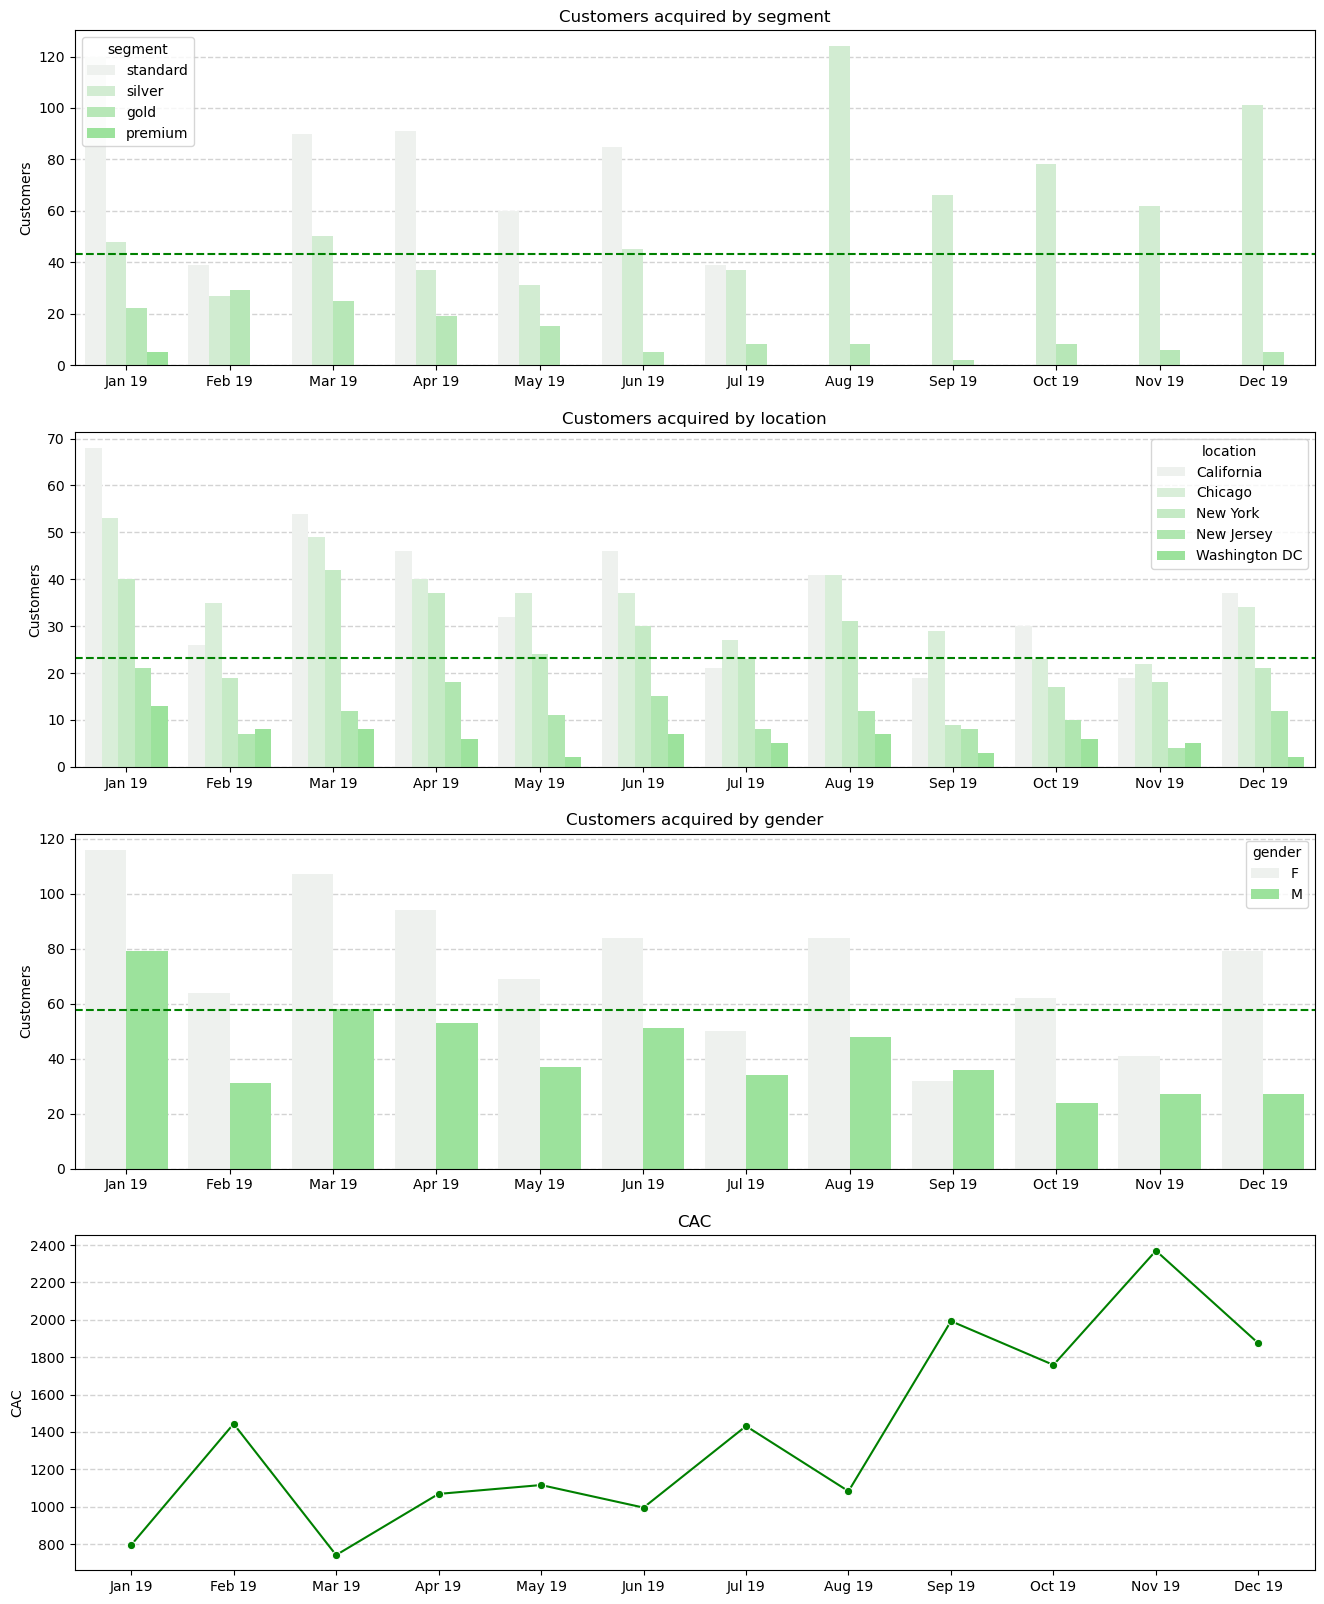

In [21]:
# Acquisition
# Min transaction date = acquisition date
customers_min_month = sales.groupby('customer_id', as_index=False).agg({'transaction_month':'min','transaction_date':'min'}) \
    .rename(columns={'transaction_month':'acquisition_month','transaction_date':'acquisition_date'})

customers_min_month['acquisition_month_name'] = customers_min_month['acquisition_month'].dt.strftime('%b %y')
sales = sales.merge(customers_min_month, on='customer_id', how='left')


# By segment
customers_min_month_acq_segment = sales.groupby(['acquisition_month','acquisition_month_name','segment'], as_index=False)['customer_id'].nunique() \
    .sort_values(['acquisition_month','customer_id'], ascending=[True, False])

avg_acquired_customers_per_month_segment = customers_min_month_acq_segment['customer_id'].mean()

# By location
customers_min_month_acq_location = sales.groupby(['acquisition_month','acquisition_month_name','location'], as_index=False)['customer_id'].nunique() \
    .sort_values(['acquisition_month','customer_id'], ascending=[True, False])

avg_acquired_customers_per_month_location = customers_min_month_acq_location['customer_id'].mean()

# By gender
customers_min_month_acq_gender = sales.groupby(['acquisition_month','acquisition_month_name','gender'], as_index=False)['customer_id'].nunique() \
    .sort_values(['acquisition_month','customer_id'], ascending=[True, False])

avg_acquired_customers_per_month_gender = customers_min_month_acq_gender['customer_id'].mean()

# CAC
marketing_spends['month'] = marketing_spends['date'].dt.to_period('M').dt.to_timestamp()
marketing_spends['total_spend'] = marketing_spends['online_spend'] + marketing_spends['offline_spend']

cac_total = customers_min_month[['acquisition_month','acquisition_month_name','customer_id']] \
    .groupby(['acquisition_month','acquisition_month_name'], as_index=False)['customer_id'].nunique() \
    .merge(
        marketing_spends.groupby('month', as_index=False)['total_spend'].sum(),
        left_on='acquisition_month',
        right_on='month',
        how='left'
    ) \
    .drop(columns='month') \
    .sort_values(['acquisition_month','customer_id'], ascending=[True, False])

cac_total['cac'] = cac_total['total_spend'] / cac_total['customer_id']


# Plotting
fig, axs = plt.subplots(4, 1, figsize=(16,20))

# Segment
ax1 = sns.barplot(data=customers_min_month_acq_segment, x='acquisition_month_name', y='customer_id', color='lightgreen', hue='segment', ax=axs[0], ci=False)
ax1.set(title='Customers acquired by segment', xlabel='', ylabel='Customers')
ax1.axhline(y=avg_acquired_customers_per_month_segment, linestyle='--', color='green')
ax1.set_axisbelow(True)
ax1.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)

# Location
ax2 = sns.barplot(data=customers_min_month_acq_location, x='acquisition_month_name', y='customer_id', color='lightgreen', hue='location', ax=axs[1], ci=False)
ax2.set(title='Customers acquired by location', xlabel='', ylabel='Customers')
ax2.axhline(y=avg_acquired_customers_per_month_location, linestyle='--', color='green')
ax2.set_axisbelow(True)
ax2.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)

# Gender
ax3 = sns.barplot(data=customers_min_month_acq_gender, x='acquisition_month_name', y='customer_id', color='lightgreen', hue='gender', ax=axs[2], ci=False)
ax3.set(title='Customers acquired by gender', xlabel='', ylabel='Customers')
ax3.axhline(y=avg_acquired_customers_per_month_gender, linestyle='--', color='green')
ax3.set_axisbelow(True)
ax3.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)

# CAC
ax4 = sns.lineplot(data=cac_total, x='acquisition_month_name', y='cac', color='green', marker='o', ax=axs[3], ci=False)
ax4.set(title='CAC', xlabel='', ylabel='CAC')
ax4.set_axisbelow(True)
ax4.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1);


Let's also visualize marketing spends by type (online/offline) to see if there are any trends:

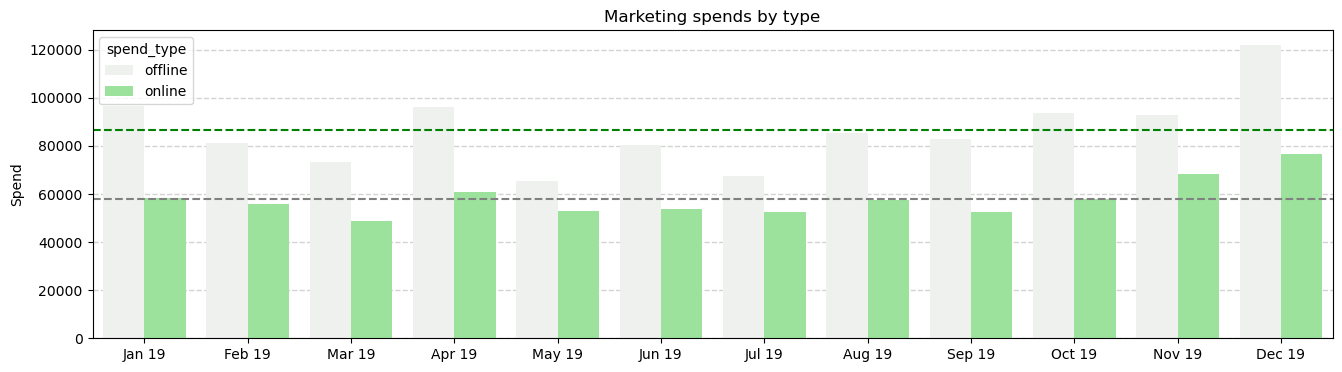

In [22]:
marketing_spends_online_offline = pd.concat([
    marketing_spends[['date','month','offline_spend']] \
        .copy() \
        .rename(columns={'offline_spend':'spend'}),
    marketing_spends[['date','month','online_spend']] \
        .copy() \
        .rename(columns={'online_spend':'spend'})],
    axis=0).reset_index(drop=True)

marketing_spends_online_offline.loc[marketing_spends_online_offline.index.isin(range(365)), 'spend_type'] = 'offline'
marketing_spends_online_offline.loc[marketing_spends_online_offline.index.isin(range(365,730)), 'spend_type'] = 'online'
marketing_spends_online_offline['month_name'] = marketing_spends_online_offline['month'].dt.strftime('%b %y')

marketing_spends_online_offline_grouped = marketing_spends_online_offline \
    .groupby(['month','month_name','spend_type'], as_index=False)['spend'] \
    .sum() \
    .sort_values(['month','spend'], ascending=[True, False])

# Average spend
avg_online_spend = marketing_spends_online_offline_grouped[marketing_spends_online_offline_grouped['spend_type'] == 'online']['spend'].mean()
avg_offline_spend = marketing_spends_online_offline_grouped[marketing_spends_online_offline_grouped['spend_type'] == 'offline']['spend'].mean()

# Plotting
ax = plt.figure(figsize=(16,4))
ax = sns.barplot(data=marketing_spends_online_offline_grouped, x='month_name', y='spend', color='lightgreen', hue='spend_type')
ax.set(title='Marketing spends by type', xlabel='', ylabel='Spend')
ax.axhline(y=avg_online_spend, linestyle='--', color='grey')
ax.axhline(y=avg_offline_spend, linestyle='--', color='green')
ax.set_axisbelow(True)
ax.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1);


- **In January 2019 almost 2x more than average** new customers were acquired to the store
- **No premium and standard customers were acquired since August 2019**
- **Acquisition cost is ~2x higher in the second half of 2019** (marketing spends increased, but less customers were acquired)
- Most customers were acquired in **California and Chicago**
- **All 5 "premium" customers were acquired in January 2019**
- **There is a slow trend of growing marketing spends (both online and offline) in the second half of the 2019**,
    the monthly online spend is ~20-30% less than offline spend on average


### Cohort analysis - retention and total revenue

Now let's calculate **retention and total revenue for each cohort** 
(where each cohort is all customers acquired in each month) to see if there are any differences
between customers acquired in different months:

In [23]:
# Finding the first activity week for each user_id
first_activity_month = customers_min_month.rename(columns={'acquisition_month': 'cohort_month'})

# Merging first week with the main dataframe
retention_data = pd.merge(sales[['customer_id','transaction_month']].drop_duplicates(), first_activity_month, on='customer_id')

# Calculating the difference (in weeks) between the first activity week and a certain week
retention_data['months_since_first_activity'] = retention_data['transaction_month'].dt.month - retention_data['cohort_month'].dt.month

# Calculating retention
def calculate_retention(retention_data):
    cohort_data = retention_data.groupby(['cohort_month', 'months_since_first_activity']).agg(n_users=('customer_id', 'nunique')).reset_index()

    cohort_sizes = cohort_data[cohort_data['months_since_first_activity'] == 0].rename(columns={'n_users': 'cohort_size'})
    cohort_data = cohort_data.merge(cohort_sizes[['cohort_month', 'cohort_size']], on='cohort_month')

    cohort_data['retention'] = cohort_data['n_users'] / cohort_data['cohort_size']

    retention = cohort_data.pivot(index='cohort_month', columns='months_since_first_activity', values='retention') \
        .reset_index() \
        .rename_axis(None, axis=1)
    
    retention['cohort_month'] = pd.to_datetime(retention['cohort_month']).dt.date

    return retention

retention = calculate_retention(retention_data)

# Coloring the table
columns_to_color = retention.columns.difference(['cohort_month'])
retention_colored = retention.fillna(0).style.background_gradient(axis=1, cmap ='Reds', subset=columns_to_color, vmin=0, vmax=0.2) \
    .format("{:.2f}", subset=columns_to_color)

retention_colored

,cohort_month,0,1,2,3,4,5,6,7,8,9,10,11
0,2019-01-01,1.00,0.05,0.11,0.13,0.10,0.21,0.14,0.18,0.09,0.11,0.10,0.16
1,2019-02-01,1.00,0.05,0.09,0.15,0.17,0.21,0.20,0.15,0.12,0.12,0.15,0.00
2,2019-03-01,1.00,0.08,0.17,0.12,0.19,0.18,0.13,0.12,0.08,0.12,0.00,0.00
3,2019-04-01,1.00,0.07,0.11,0.16,0.10,0.08,0.07,0.10,0.09,0.00,0.00,0.00
4,2019-05-01,1.00,0.08,0.08,0.12,0.08,0.10,0.12,0.08,0.00,0.00,0.00,0.00
5,2019-06-01,1.00,0.11,0.13,0.07,0.09,0.10,0.07,0.00,0.00,0.00,0.00,0.00
6,2019-07-01,1.00,0.11,0.05,0.04,0.10,0.07,0.00,0.00,0.00,0.00,0.00,0.00
7,2019-08-01,1.00,0.08,0.10,0.08,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,2019-09-01,1.00,0.04,0.04,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,2019-10-01,1.00,0.07,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


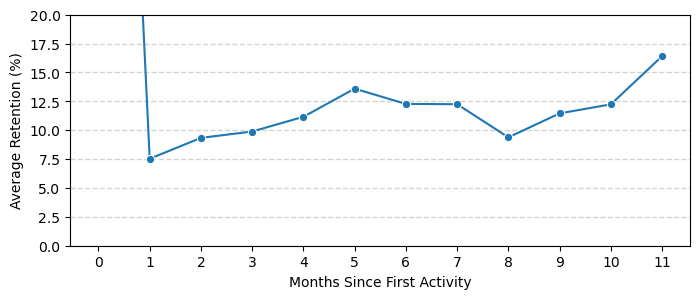

In [24]:
# Now let's calculate average n-week retention for a clearer image

# Calculating average retention rate for each number of weeks
avg_retention_by_week = retention.drop(columns=['cohort_month']).apply(lambda x: x.dropna().mean())

avg_retention = avg_retention_by_week.reset_index()
avg_retention.columns = ['months_since_first_activity', 'avg_retention']
avg_retention['avg_retention'] = avg_retention['avg_retention'] * 100

# Plotting
ax = plt.figure(figsize=(8, 3))
ax = sns.lineplot(data=avg_retention, x='months_since_first_activity', y='avg_retention', marker='o')

plt.xlabel('Months Since First Activity')
plt.ylabel('Average Retention (%)')
plt.ylim(0, 20)
plt.xticks(avg_retention['months_since_first_activity'])

ax.set_axisbelow(True)
ax.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)

plt.show();


- The retention in most cohorts and average retention look unusual - **instead of a gradual decline each next month
    it drops 92.5% (!) on the first month and then gradually increases in the next months**.

    This can be due to the fact that this data was generated synthetically and customers' behavior was
    not generated good enough, but also **this behavior may be related to the specifics of e-commerce business, 
    where, unlike, for example, social networks, users may make a purchase once every few months**

- **Retention among the first 3 cohorts is higher almost every week than retention of other cohorts**


In [25]:
# Merging first week with the main dataframe
purchases_data = pd.merge(
    sales[['revenue', 'customer_id', 'transaction_month']], 
    first_activity_month, 
    on='customer_id')

# Calculating the difference (in weeks) between the first activity week and a certain week
purchases_data['months_since_first_activity'] = purchases_data['transaction_month'].dt.month - purchases_data['cohort_month'].dt.month

# Calculating sum of purchases per week for each cohort
cohort_data = purchases_data.groupby(['cohort_month', 'months_since_first_activity']).agg(purchases=('revenue', 'sum')).reset_index()

purchases_sum = cohort_data.pivot(index='cohort_month', columns='months_since_first_activity', values='purchases') \
        .reset_index() \
        .rename_axis(None, axis=1)

purchases_sum['cohort_month'] = pd.to_datetime(purchases_sum['cohort_month']).dt.date
# purchases_sum
# Coloring the table
columns_to_color = purchases_sum.columns.difference(['cohort_month'])
purchases_colored = purchases_sum \
    .fillna(0) \
    .style.background_gradient(axis=1, cmap ='Reds', subset=columns_to_color, vmin=0, vmax=100000) \
    .format("{:.0f}", subset=columns_to_color)

purchases_colored


,cohort_month,0,1,2,3,4,5,6,7,8,9,10,11
0,2019-01-01,497367,45329,60644,121437,31601,55349,103205,58190,41468,46318,41544,93816
1,2019-02-01,331831,9131,20817,24884,26480,52797,33971,48933,20411,24232,45183,0
2,2019-03-01,349404,53880,43744,30141,68892,90793,47985,41117,33102,43277,0,0
3,2019-04-01,300411,19839,25355,38118,29485,41646,20782,62460,21805,0,0,0
4,2019-05-01,250830,7177,16452,19174,18330,44685,40281,11800,0,0,0,0
5,2019-06-01,220038,14852,17643,20402,13811,40650,16015,0,0,0,0,0
6,2019-07-01,178741,11478,8335,15891,23301,20085,0,0,0,0,0,0
7,2019-08-01,243045,12513,14929,33257,17985,0,0,0,0,0,0,0
8,2019-09-01,164330,2024,3528,563,0,0,0,0,0,0,0,0
9,2019-10-01,255925,10034,2965,0,0,0,0,0,0,0,0,0


- The situation is similar to retention - **the first half of cohorts have higher total monthly revenue
    (in the first month too)**

### Revenue and profit analysis, ARPU

Now let's dive deeper into the revenue and plot the distributions by gender, location, and segment.

We can also calculate the profit = revenue - marketing spends.


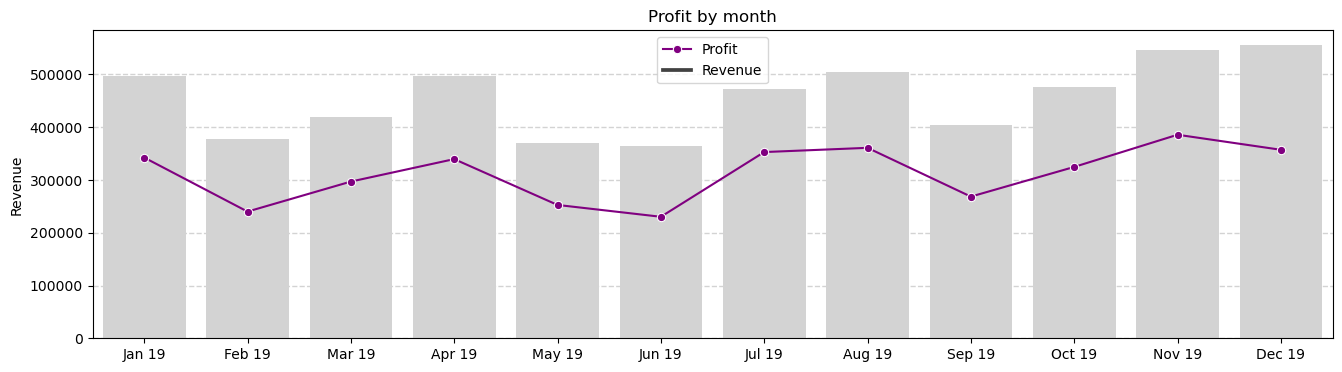

In [26]:
# Monthly profit
# Calculating spends
# marketing_spends['month'] = marketing_spends['date'].dt.to_period('M').dt.to_timestamp()
# marketing_spends['total_spend'] = marketing_spends['online_spend'] + marketing_spends['offline_spend']

revenue_total = sales \
    .groupby(['transaction_month','transaction_month_name'], as_index=False).agg({
        'revenue':'sum',
        'customer_id':'nunique'}) \
    .sort_values(['transaction_month','revenue'], ascending=[True, False])

avg_revenue = revenue_total['revenue'].mean()

profit_per_month = sales \
    .groupby(['transaction_month','transaction_month_name'], as_index=False)['revenue'].sum() \
    .merge(
        marketing_spends.groupby('month', as_index=False)['total_spend'].sum(),
        left_on='transaction_month',
        right_on='month',
        how='left'
    ) \
    .drop(columns='month') \
    .sort_values(['transaction_month','revenue'], ascending=[True, False])

profit_per_month['profit'] = profit_per_month['revenue'] - profit_per_month['total_spend']

# Plotting profit
ax = plt.figure(figsize=(16,4))

ax1 = sns.lineplot(data=profit_per_month, x='transaction_month_name', y='profit', color='purple', marker='o', legend='full')
ax1.set(title='Profit by month', xlabel='', ylabel='Profit')
ax2 = sns.barplot(data=revenue_total, x='transaction_month_name', y='revenue', color='lightgrey')
ax2.set(xlabel='', ylabel='Revenue')

ax1.legend(['Profit','Revenue'])
ax1.set_axisbelow(True)
ax1.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)

- There is **a trend in increasing revenue in the last 4 months of 2019 
    (and for the first time in 2019 revenue crossed the 500000 level)**
- **Profit line basically copies revenue, because marketing spends are increasing/decreasing with the revenue**
- **In December 2019 there is a drop in profit due to increased marketing spends**
- The data shows some **seasonality in both revenue and profit - every 3-4 months there is a drop of volume**

Now let's plot the revenue and ARPU:

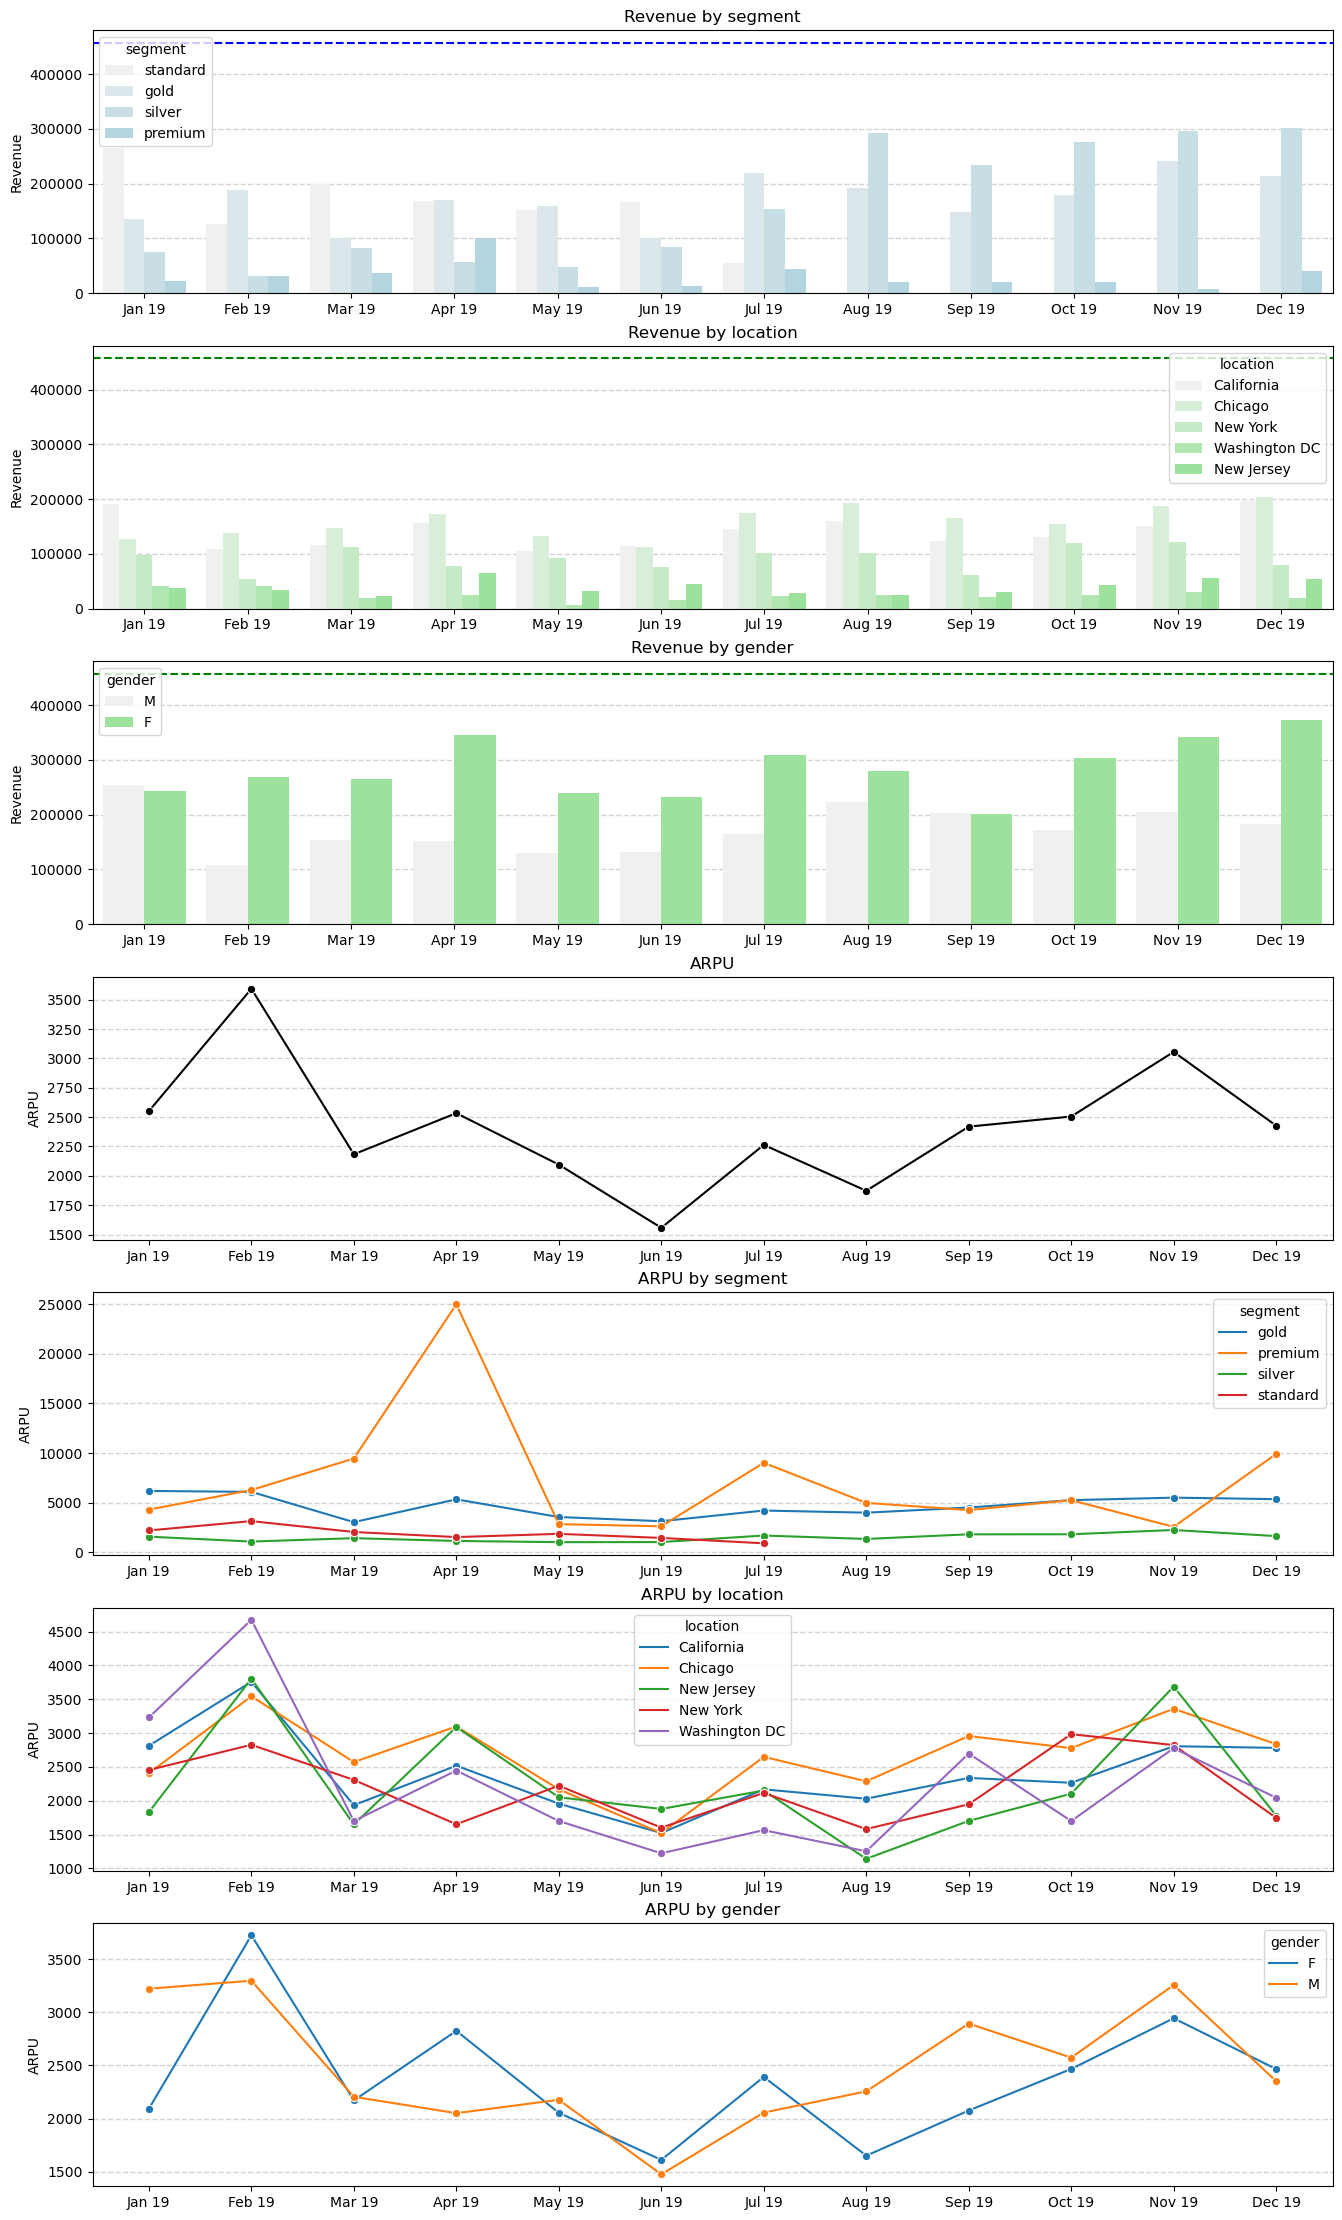

In [27]:
# Monthly revenue
revenue_by_segment = sales \
    .groupby(['transaction_month','transaction_month_name','segment'], as_index=False).agg({
        'revenue':'sum',
        'customer_id':'nunique'}) \
    .sort_values(['transaction_month','revenue'], ascending=[True, False])

revenue_by_location = sales \
    .groupby(['transaction_month','transaction_month_name','location'], as_index=False).agg({
        'revenue':'sum',
        'customer_id':'nunique'}) \
    .sort_values(['transaction_month','revenue'], ascending=[True, False])

revenue_by_gender = sales \
    .groupby(['transaction_month','transaction_month_name','gender'], as_index=False).agg({
        'revenue':'sum',
        'customer_id':'nunique'}) \
    .sort_values(['transaction_month','revenue'], ascending=[True, False])

# Monthly ARPU
arpu_total = sales.groupby(['transaction_month','transaction_month_name'], as_index=False).agg({
    'revenue':'sum',
    'customer_id':'nunique'
}).assign(arpu=lambda x: x['revenue'] / x['customer_id'])

avg_revenue_per_month = arpu_total['revenue'].mean()


arpu_location = sales.groupby(['transaction_month','transaction_month_name','location'], as_index=False).agg({
    'revenue':'sum',
    'customer_id':'nunique'
}).assign(arpu=lambda x: x['revenue'] / x['customer_id'])

arpu_segment = sales.groupby(['transaction_month','transaction_month_name','segment'], as_index=False).agg({
    'revenue':'sum',
    'customer_id':'nunique'
}).assign(arpu=lambda x: x['revenue'] / x['customer_id'])

arpu_gender = sales.groupby(['transaction_month','transaction_month_name','gender'], as_index=False).agg({
    'revenue':'sum',
    'customer_id':'nunique'
}).assign(arpu=lambda x: x['revenue'] / x['customer_id'])


# Plotting
fig, axs = plt.subplots(7, 1, figsize=(16,28))

# Revenue by segment
ax1 = sns.barplot(data=revenue_by_segment, x='transaction_month_name', y='revenue', color='lightblue', ax=axs[0], hue='segment', ci=False)
ax1.set(title='Revenue by segment', xlabel='', ylabel='Revenue')
ax1.axhline(y=avg_revenue, linestyle='--', color='blue')
ax1.set_axisbelow(True)
ax1.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)

# Revenue by location
ax2 = sns.barplot(data=revenue_by_location, x='transaction_month_name', y='revenue', color='lightgreen', ax=axs[1], hue='location', ci=False)
ax2.set(title='Revenue by location', xlabel='', ylabel='Revenue')
ax2.axhline(y=avg_revenue, linestyle='--', color='green')
ax2.set_axisbelow(True)
ax2.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)

# Revenue by location
ax3 = sns.barplot(data=revenue_by_gender, x='transaction_month_name', y='revenue', color='lightgreen', ax=axs[2], hue='gender', ci=False)
ax3.set(title='Revenue by gender', xlabel='', ylabel='Revenue')
ax3.axhline(y=avg_revenue, linestyle='--', color='green')
ax3.set_axisbelow(True)
ax3.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)


# ARPU
ax4 = sns.lineplot(data=arpu_total, x='transaction_month_name', y='arpu', color='black', ax=axs[3], marker='o', legend='full')
ax4.set(title='ARPU', xlabel='', ylabel='ARPU')
ax4.set_axisbelow(True)
ax4.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)

# ARPU by segment
ax5 = sns.lineplot(data=arpu_segment, x='transaction_month_name', y='arpu', ax=axs[4], marker='o', hue='segment')
ax5.set(title='ARPU by segment', xlabel='', ylabel='ARPU')
ax5.set_axisbelow(True)
ax5.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)

# ARPU by location
ax6 = sns.lineplot(data=arpu_location, x='transaction_month_name', y='arpu', ax=axs[5], marker='o', hue='location')
ax6.set(title='ARPU by location', xlabel='', ylabel='ARPU')
ax6.set_axisbelow(True)
ax6.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)

# ARPU by gender
ax7 = sns.lineplot(data=arpu_gender, x='transaction_month_name', y='arpu', ax=axs[6], marker='o', hue='gender')
ax7.set(title='ARPU by gender', xlabel='', ylabel='ARPU')
ax7.set_axisbelow(True)
ax7.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1);


Revenue insights:
- Overall the **revenue is mostly generated by gold and silver customers**
- However, **in December 2019 a slight growth in revenue was generated by premium customers (mostly women)**
- There were **only 2 months where men generated the same revenue as women (January and September 2019)**
- **Since the beginning of 2019 more customers from Chicago and New Jersey started generating revenue,
    at the same time the revenue from Washington DC decreased**

ARPU insights:
- **ARPU was at its maximum in February and at its minimum in June 2019, now it's in its medium range**
- **Premium customers don't influence ARPU much** (for example, a 2.5x growth in premium segment in April 2019 
    resulted in a very minor ARPU growth, and in December 2019 ARPU decreased significantly even though premium segment grew)
- At the beginning of the year Washington DC's ARPU was the highest, but at the end of the year it is among the last
- **During the year men's and women's ARPU fluctuated, but in December they are almost the same**

Let's analyze the revenue in terms of product categories customers buy during the year:


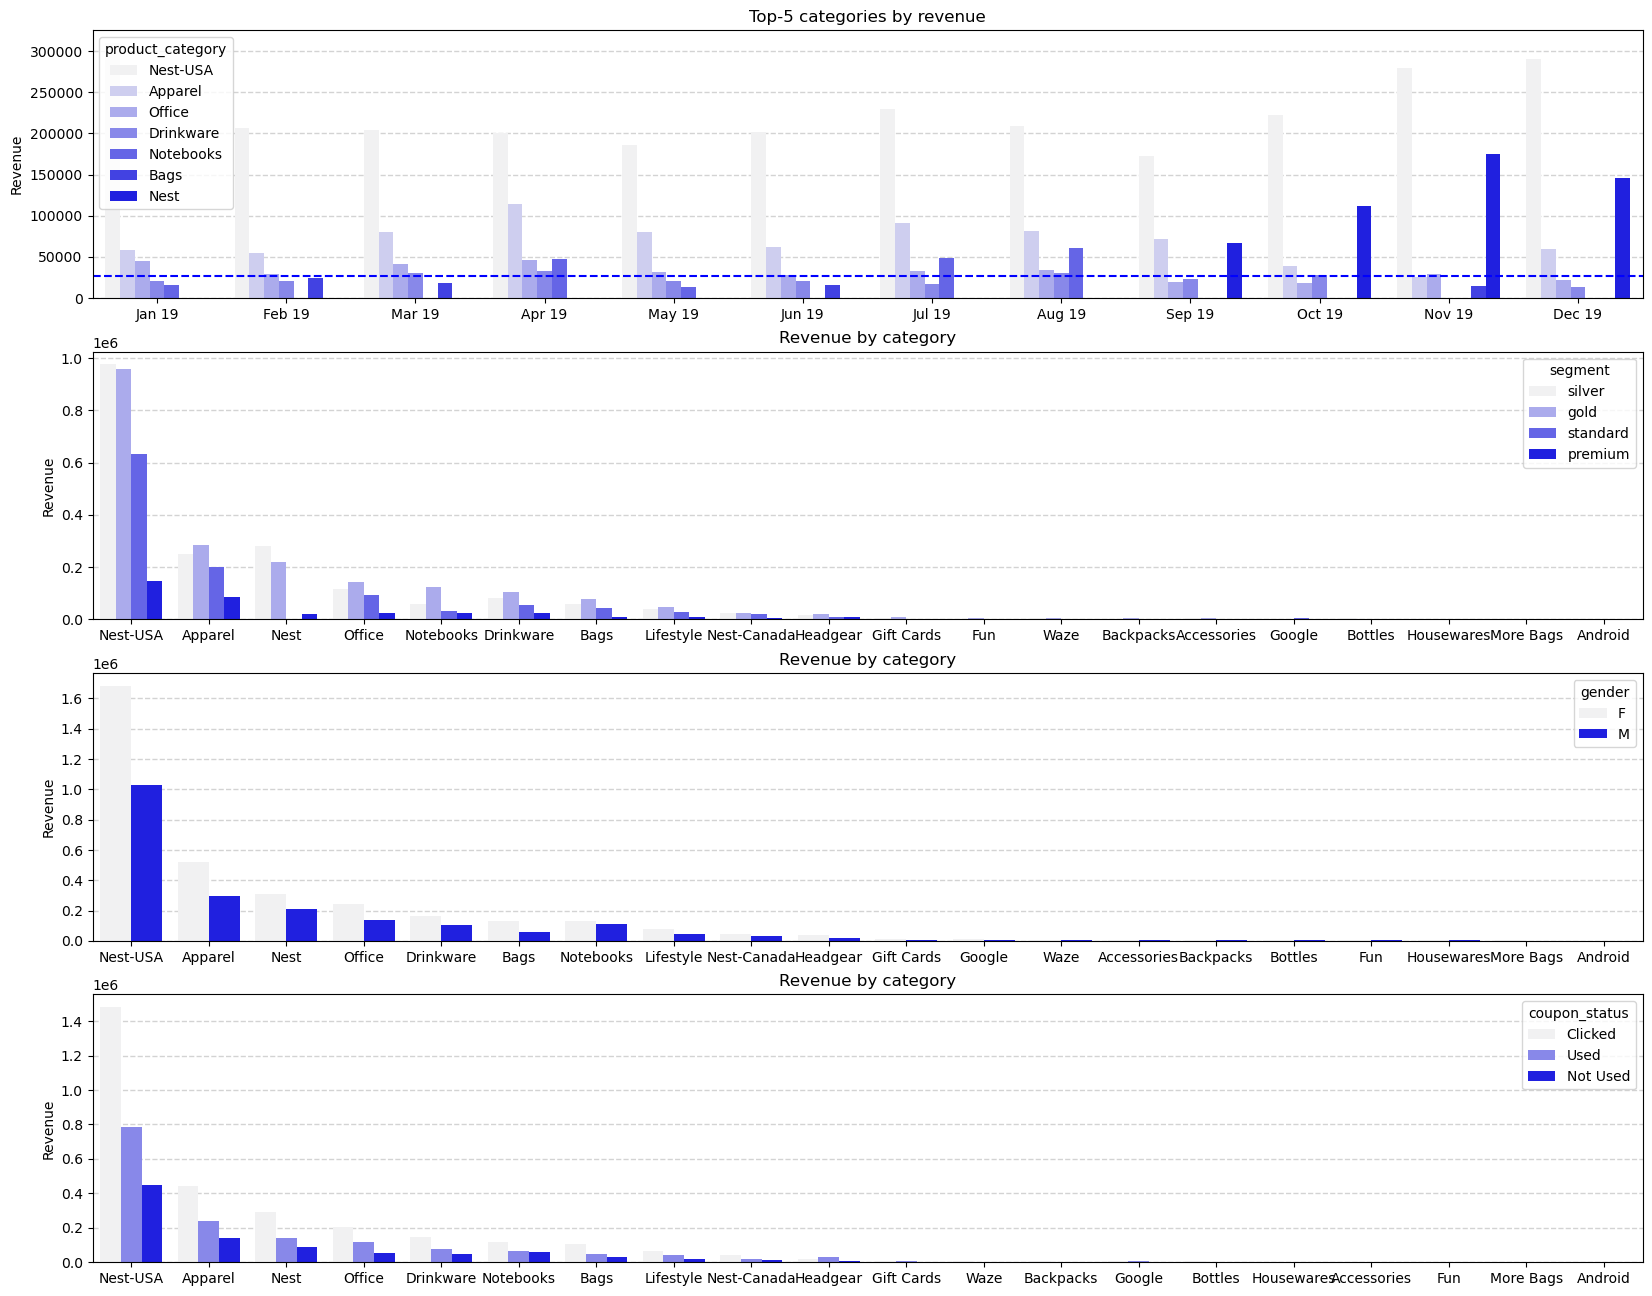

In [28]:
# Top-5 categories by revenue
monthly_category_revenue = sales.groupby(['transaction_month','transaction_month_name','product_category'], as_index=False)['revenue'].sum()

avg_revenue_per_category = monthly_category_revenue['revenue'].mean()

monthly_category_revenue_sorted = monthly_category_revenue.sort_values(['transaction_month', 'revenue'], ascending=[True, False])
top_5_categories_by_month = monthly_category_revenue_sorted.groupby(['transaction_month', 'transaction_month_name']).head(5)

# Revenue by category by segment
revenue_by_category_segment = sales.groupby(['product_category','segment'], as_index=False)['revenue'].sum() \
    .sort_values(['revenue', 'product_category'], ascending=[False, True])

# Revenue by category by gender
revenue_by_category_gender = sales.groupby(['product_category','gender'], as_index=False)['revenue'].sum() \
    .sort_values(['revenue', 'product_category'], ascending=[False, True])

# Revenue by category by discounts
revenue_by_category_coupon = sales.groupby(['product_category','coupon_status'], as_index=False)['revenue'].sum() \
    .sort_values(['revenue', 'product_category'], ascending=[False, True])

# Plotting
fig, axs = plt.subplots(4, 1, figsize=(20,16))

ax1 = sns.barplot(data=top_5_categories_by_month, x='transaction_month_name', y='revenue', color='blue', hue='product_category', ax=axs[0], ci=False)
ax1.set(title='Top-5 categories by revenue', xlabel='', ylabel='Revenue')
ax1.axhline(y=avg_revenue_per_category, linestyle='--', color='blue')
ax1.set_axisbelow(True)
ax1.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)

# Categories by segment
ax2 = sns.barplot(data=revenue_by_category_segment, x='product_category', y='revenue', hue='segment', color='blue', ax=axs[1], ci=False)
ax2.set(title='Revenue by category', xlabel='', ylabel='Revenue')
# ax2.axhline(y=avg_revenue_per_category, linestyle='--', color='green')
ax2.set_axisbelow(True)
ax2.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)
# ax2.tick_params('x', labelrotation=45)

# Categories by gender
ax3 = sns.barplot(data=revenue_by_category_gender, x='product_category', y='revenue', hue='gender', color='blue', ax=axs[2], ci=False)
ax3.set(title='Revenue by category', xlabel='', ylabel='Revenue')
# ax3.axhline(y=avg_revenue_per_category, linestyle='--', color='green')
ax3.set_axisbelow(True)
ax3.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)
# ax3.tick_params('x', labelrotation=45)

# Categories by discount
ax4 = sns.barplot(data=revenue_by_category_coupon, x='product_category', y='revenue', hue='coupon_status', color='blue', ax=axs[3], ci=False)
ax4.set(title='Revenue by category', xlabel='', ylabel='Revenue')
# ax4.axhline(y=avg_revenue_per_category, linestyle='--', color='green')
ax4.set_axisbelow(True)
ax4.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)
# ax4.tick_params('x', labelrotation=45)


- Since the beginning of the year **customers started to buy "Nest" category instead of "Bags" and "Notebooks"**
- **"Nest-USA" is the category that generates the most revenue overall**
- **Most revenue is generated in orders where coupon codes are either not used or clicked (which is equal to "Not Used")**
- There are **no big differences in terms of gender**
- **"Nest" is the category that no "standard" customers purchased from**


### Number of orders, AOV

Now let's analyse the orders - their overall quantity, average order value (AOV), etc.

***In the data each order is a unique transaction_id**

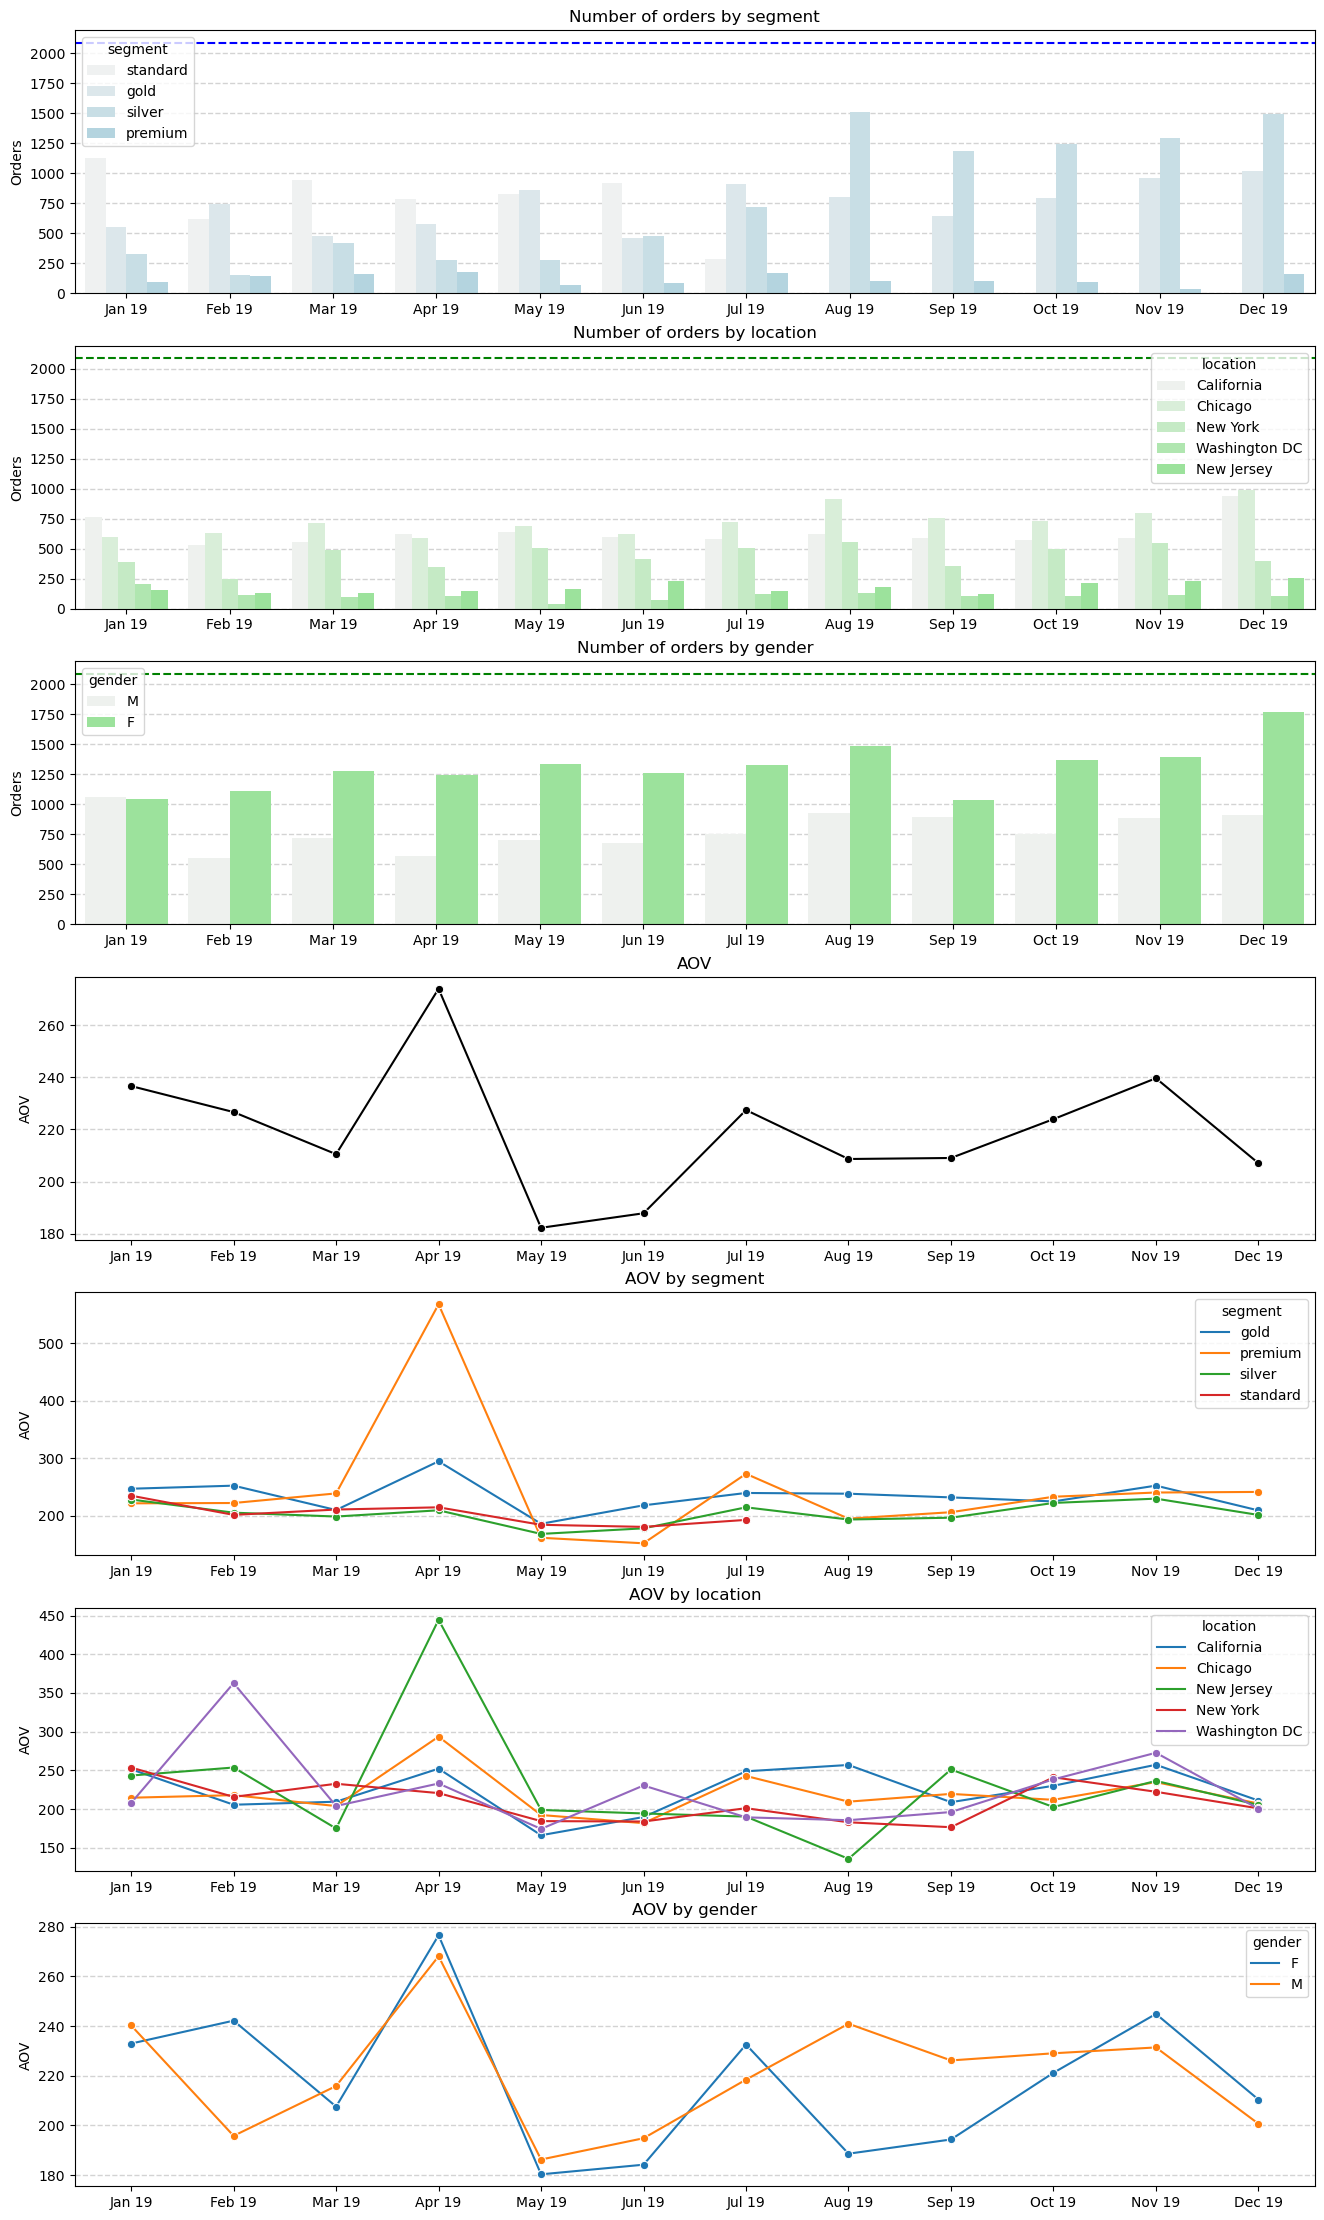

In [29]:
# Number of orders
num_of_orders = sales \
    .groupby(['transaction_month','transaction_month_name'], as_index=False).agg({'revenue':'sum', 'transaction_id':'nunique'}) \
    .rename(columns={'transaction_id':'orders'}) \
    .sort_values(['transaction_month','orders'], ascending=[True, False])

num_of_orders_segment = sales \
    .groupby(['transaction_month','transaction_month_name','segment'], as_index=False).agg({'revenue':'sum', 'transaction_id':'nunique'}) \
    .rename(columns={'transaction_id':'orders'}) \
    .sort_values(['transaction_month','orders'], ascending=[True, False])

num_of_orders_location = sales \
    .groupby(['transaction_month','transaction_month_name','location'], as_index=False).agg({'revenue':'sum', 'transaction_id':'nunique'}) \
    .rename(columns={'transaction_id':'orders'}) \
    .sort_values(['transaction_month','orders'], ascending=[True, False])

num_of_orders_gender = sales \
    .groupby(['transaction_month','transaction_month_name','gender'], as_index=False).agg({'revenue':'sum', 'transaction_id':'nunique'}) \
    .rename(columns={'transaction_id':'orders'}) \
    .sort_values(['transaction_month','orders'], ascending=[True, False])

avg_orders = num_of_orders['orders'].mean()

# Average order value (AOV)
aov_total = num_of_orders.groupby(['transaction_month', 'transaction_month_name'], as_index=False) \
    .agg({'revenue':'sum', 'orders':'sum'}) \
    .assign(aov=lambda x: x['revenue'] / x['orders'])

aov_segment = num_of_orders_segment.groupby(['transaction_month', 'transaction_month_name','segment'], as_index=False) \
    .agg({'revenue':'sum', 'orders':'sum'}) \
    .assign(aov=lambda x: x['revenue'] / x['orders'])

aov_location = num_of_orders_location.groupby(['transaction_month', 'transaction_month_name','location'], as_index=False) \
    .agg({'revenue':'sum', 'orders':'sum'}) \
    .assign(aov=lambda x: x['revenue'] / x['orders'])

aov_gender = num_of_orders_gender.groupby(['transaction_month', 'transaction_month_name','gender'], as_index=False) \
    .agg({'revenue':'sum', 'orders':'sum'}) \
    .assign(aov=lambda x: x['revenue'] / x['orders'])

# Plotting
fig, axs = plt.subplots(7, 1, figsize=(16,28))

# Orders by segment
ax1 = sns.barplot(data=num_of_orders_segment, x='transaction_month_name', y='orders', color='lightblue', ax=axs[0], hue='segment', ci=False)
ax1.set(title='Number of orders by segment', xlabel='', ylabel='Orders')
ax1.axhline(y=avg_orders, linestyle='--', color='blue')
ax1.set_axisbelow(True)
ax1.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)

# Orders by location
ax2 = sns.barplot(data=num_of_orders_location, x='transaction_month_name', y='orders', color='lightgreen', ax=axs[1], hue='location', ci=False)
ax2.set(title='Number of orders by location', xlabel='', ylabel='Orders')
ax2.axhline(y=avg_orders, linestyle='--', color='green')
ax2.set_axisbelow(True)
ax2.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)

# Orders by gender
ax3 = sns.barplot(data=num_of_orders_gender, x='transaction_month_name', y='orders', color='lightgreen', ax=axs[2], hue='gender', ci=False)
ax3.set(title='Number of orders by gender', xlabel='', ylabel='Orders')
ax3.axhline(y=avg_orders, linestyle='--', color='green')
ax3.set_axisbelow(True)
ax3.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)

# AOV
ax4 = sns.lineplot(data=aov_total, x='transaction_month_name', y='aov', color='black', ax=axs[3], marker='o', legend='full')
ax4.set(title='AOV', xlabel='', ylabel='AOV')
ax4.set_axisbelow(True)
ax4.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)

# AOV by segment
ax5 = sns.lineplot(data=aov_segment, x='transaction_month_name', y='aov', ax=axs[4], marker='o', hue='segment')
ax5.set(title='AOV by segment', xlabel='', ylabel='AOV')
ax5.set_axisbelow(True)
ax5.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)

# AOV by location
ax6 = sns.lineplot(data=aov_location, x='transaction_month_name', y='aov', ax=axs[5], marker='o', hue='location')
ax6.set(title='AOV by location', xlabel='', ylabel='AOV')
ax6.set_axisbelow(True)
ax6.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)

# AOV by gender
ax7 = sns.lineplot(data=aov_gender, x='transaction_month_name', y='aov', ax=axs[6], marker='o', hue='gender')
ax7.set(title='AOV by gender', xlabel='', ylabel='AOV')
ax7.set_axisbelow(True)
ax7.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1);


- **Since the beginning of the year more orders were placed in California, Chicago, and New Jersey, 
    and less orders were placed in Washington DC**
- There is a **trend in increasing number of orders in the last 4 months of 2019**
- There is an **overall increase in the number of orders during the year**
- **In April 2019 AOV increased significantly due to more orders placed by premium customers (men and women) in New Jersey**
- **In May 2019, however, AOV was on its minimum** (almost 2x lower than in April)

What about average number of orders per customer?

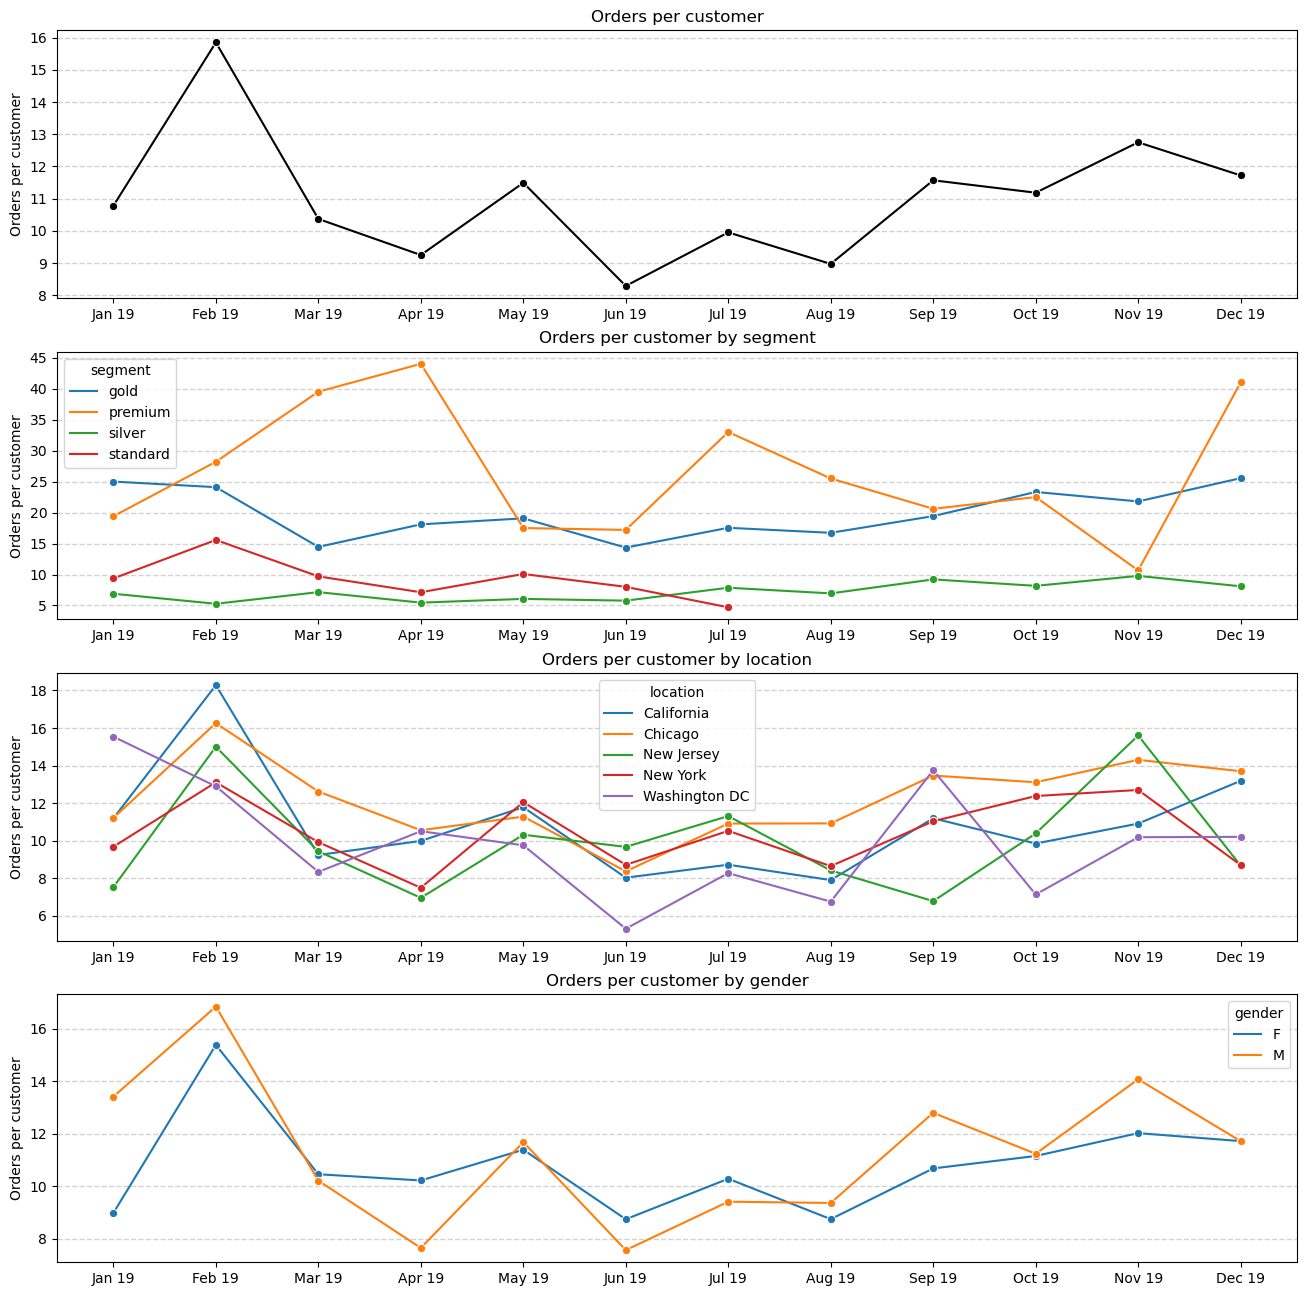

In [30]:
orders_per_customer = sales.groupby(['transaction_month','transaction_month_name'], as_index=False) \
    .agg({'customer_id':'nunique', 'transaction_id':'nunique'}) \
    .rename(columns={'customer_id':'customers', 'transaction_id':'orders'})

avg_orders_per_customer = orders_per_customer['orders'].sum() / orders_per_customer['customers'].sum()

orders_per_customer_segment = sales.groupby(['transaction_month','transaction_month_name','segment'], as_index=False) \
    .agg({'customer_id':'nunique', 'transaction_id':'nunique'}) \
    .rename(columns={'customer_id':'customers', 'transaction_id':'orders'})

orders_per_customer_location = sales.groupby(['transaction_month','transaction_month_name','location'], as_index=False) \
    .agg({'customer_id':'nunique', 'transaction_id':'nunique'}) \
    .rename(columns={'customer_id':'customers', 'transaction_id':'orders'})

orders_per_customer_gender = sales.groupby(['transaction_month','transaction_month_name','gender'], as_index=False) \
    .agg({'customer_id':'nunique', 'transaction_id':'nunique'}) \
    .rename(columns={'customer_id':'customers', 'transaction_id':'orders'})

# Average orders per customer
avg_orders_total = orders_per_customer.groupby(['transaction_month', 'transaction_month_name'], as_index=False) \
    .agg({'customers':'sum', 'orders':'sum'}) \
    .assign(orders_per_customer=lambda x: x['orders'] / x['customers'])

avg_orders_segment = orders_per_customer_segment.groupby(['transaction_month', 'transaction_month_name', 'segment'], as_index=False) \
    .agg({'customers':'sum', 'orders':'sum'}) \
    .assign(orders_per_customer=lambda x: x['orders'] / x['customers'])

avg_orders_location = orders_per_customer_location.groupby(['transaction_month', 'transaction_month_name', 'location'], as_index=False) \
    .agg({'customers':'sum', 'orders':'sum'}) \
    .assign(orders_per_customer=lambda x: x['orders'] / x['customers'])

avg_orders_gender = orders_per_customer_gender.groupby(['transaction_month', 'transaction_month_name', 'gender'], as_index=False) \
    .agg({'customers':'sum', 'orders':'sum'}) \
    .assign(orders_per_customer=lambda x: x['orders'] / x['customers'])


# Plotting
fig, axs = plt.subplots(4, 1, figsize=(16,16))

# Average orders per customer
ax1 = sns.lineplot(data=avg_orders_total, x='transaction_month_name', y='orders_per_customer', color='black', ax=axs[0], marker='o')
ax1.set(title='Orders per customer', xlabel='', ylabel='Orders per customer')
ax1.set_axisbelow(True)
ax1.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)

# Average orders per customer by segment
ax2 = sns.lineplot(data=avg_orders_segment, x='transaction_month_name', y='orders_per_customer', ax=axs[1], marker='o', hue='segment')
ax2.set(title='Orders per customer by segment', xlabel='', ylabel='Orders per customer')
ax2.set_axisbelow(True)
ax2.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)

# Average orders per customer by location
ax3 = sns.lineplot(data=avg_orders_location, x='transaction_month_name', y='orders_per_customer', ax=axs[2], marker='o', hue='location')
ax3.set(title='Orders per customer by location', xlabel='', ylabel='Orders per customer')
ax3.set_axisbelow(True)
ax3.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)

# Average orders per customer by gender
ax4 = sns.lineplot(data=avg_orders_gender, x='transaction_month_name', y='orders_per_customer', ax=axs[3], marker='o', hue='gender')
ax4.set(title='Orders per customer by gender', xlabel='', ylabel='Orders per customer')
ax4.set_axisbelow(True)
ax4.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1);


- In **February 2019 there was a 1.5x increase in orders per customer among both men and women and among different locations**
- **Premium segment is the most volatile (in December 2019 it grew 4x!), but other segments are more or less stable**


### Products, categories, and discounts analysis

Finally, let's take a look at products, product categories, etc.


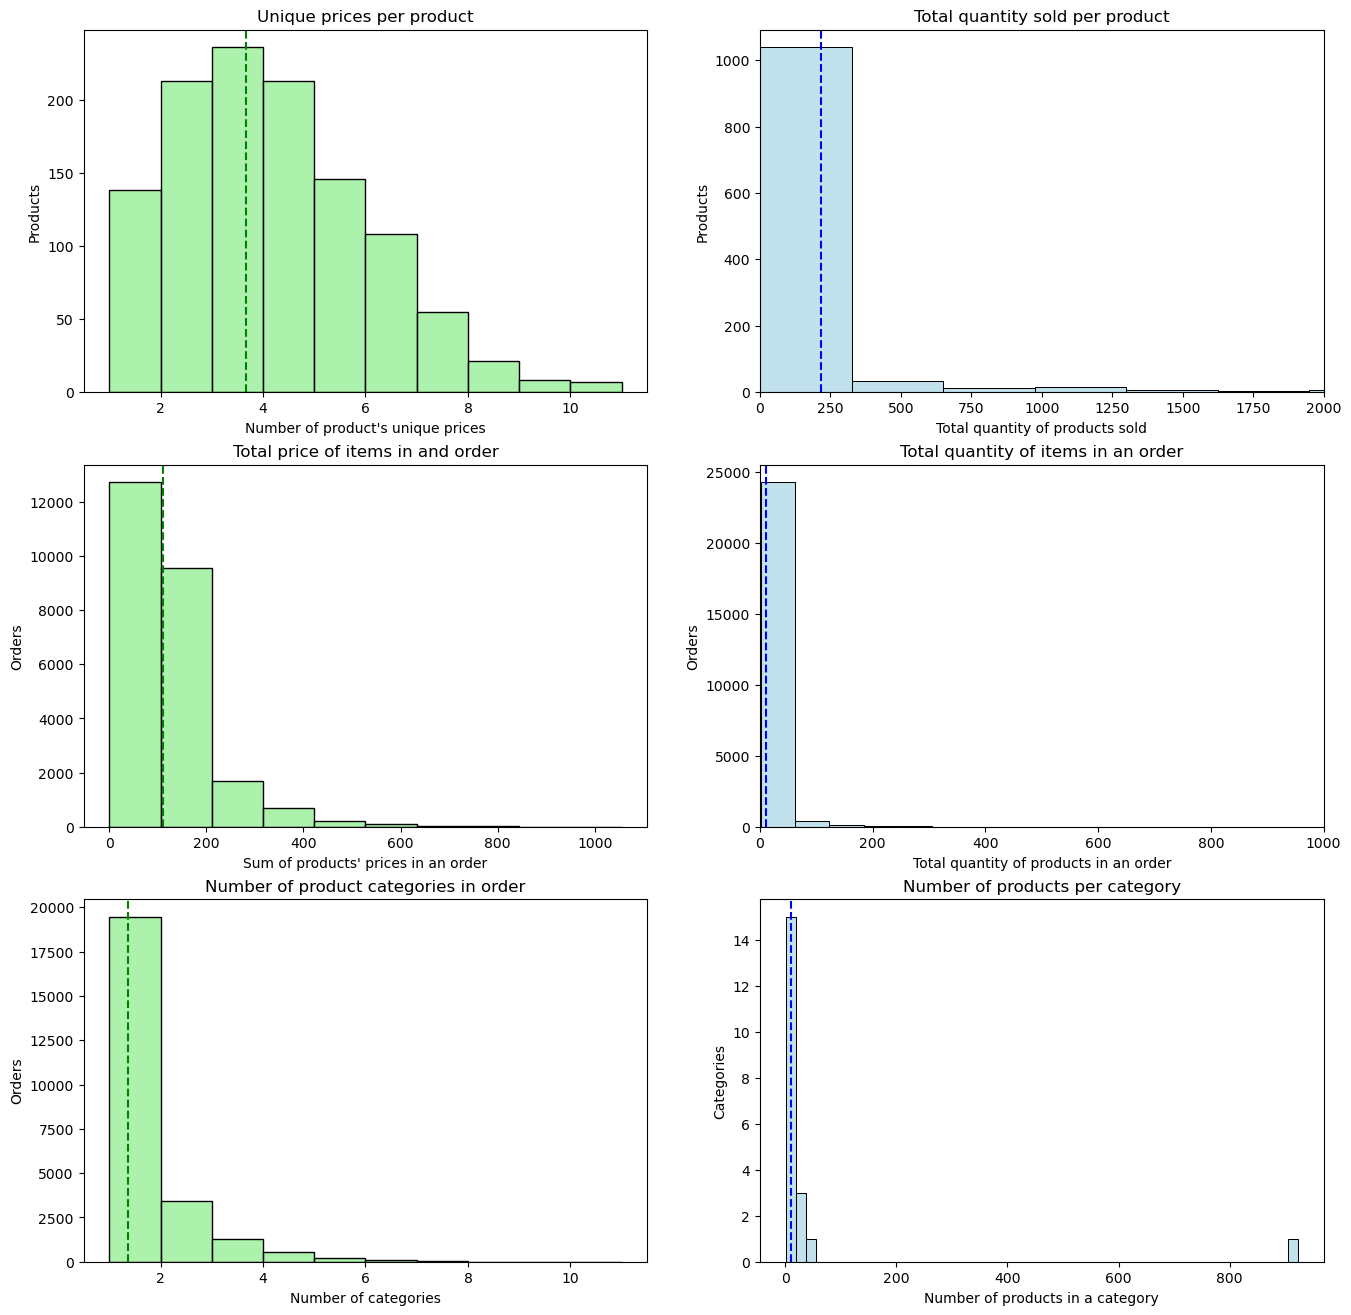

In [31]:
# Number of unique prices each product has/had
product_prices_dist = sales.groupby('product_sku', as_index=False)['price'].nunique()
product_prices_dist_mean = product_prices_dist['price'].mean()

# Total quantity of each product sold
product_quantity_dist = sales.groupby('product_sku', as_index=False)['quantity'].sum()
product_quantity_dist_mean = product_quantity_dist['quantity'].mean()

# Number of unique prices each product has/had
sales_prices_dist = sales.groupby('transaction_id', as_index=False)['price'].sum()
sales_prices_dist_mean = sales_prices_dist['price'].mean()

# Total quantity of each product sold
sales_quantity_dist = sales.groupby('transaction_id', as_index=False)['quantity'].sum()
sales_quantity_dist_mean = sales_quantity_dist['quantity'].mean()

# Number of unique prices each product has/had
sales_categories_dist = sales.groupby('transaction_id', as_index=False)['category_id'].nunique()
sales_categories_dist_mean = sales_categories_dist['category_id'].mean()

# Total quantity of each product sold
products_per_catrgory_dist = sales.groupby('category_id', as_index=False)['product_sku'].nunique()
products_per_catrgory_dist_mean = products_per_catrgory_dist['product_sku'].mean()


# Plotting
fig, axs = plt.subplots(3, 2, figsize=(16,16))

ax1 = sns.histplot(data=product_prices_dist, x='price', color='lightgreen', bins=10, ax=axs[0,0])
ax1.set(title='Unique prices per product', xlabel="Number of product's unique prices", ylabel='Products')
ax1.axvline(x=product_prices_dist_mean, linestyle='--', color='green')

ax2 = sns.histplot(data=product_quantity_dist, x='quantity', color='lightblue', bins=50, ax=axs[0,1])
ax2.set(title='Total quantity sold per product', xlabel='Total quantity of products sold', ylabel='Products')
ax2.axvline(x=product_quantity_dist_mean, linestyle='--', color='blue')
ax2.set_xlim(0,2000)

ax3 = sns.histplot(data=sales_prices_dist, x='price', color='lightgreen', bins=10, ax=axs[1,0])
ax3.set(title="Total price of items in and order", xlabel="Sum of products' prices in an order", ylabel='Orders')
ax3.axvline(x=sales_prices_dist_mean, linestyle='--', color='green')

ax4 = sns.histplot(data=sales_quantity_dist, x='quantity', color='lightblue', bins=50, ax=axs[1,1])
ax4.set(title='Total quantity of items in an order', xlabel='Total quantity of products in an order', ylabel='Orders')
ax4.axvline(x=sales_quantity_dist_mean, linestyle='--', color='blue')
ax4.set_xlim(0,1000)

ax5 = sns.histplot(data=sales_categories_dist, x='category_id', color='lightgreen', bins=10, ax=axs[2,0])
ax5.set(title="Number of product categories in order", xlabel="Number of categories", ylabel='Orders')
ax5.axvline(x=sales_categories_dist_mean, linestyle='--', color='green')

ax6 = sns.histplot(data=products_per_catrgory_dist, x='product_sku', color='lightblue', bins=50, ax=axs[2,1])
ax6.set(title='Number of products per category', xlabel='Number of products in a category', ylabel='Categories')
ax6.axvline(x=sales_quantity_dist_mean, linestyle='--', color='blue');


- On average, **each product has 3-4 price changes during the year observed** 
    (some products, however, changed price more than 10 times)
- On average, **most products were sold in the amount of 200 items in total**
- Average **total price of products in an order is ~100**
- On average, **total quantity of items in an order is ~10**
- On average, **in one order customer purchases products from just 1 category**
- **In most categories the number of products is <10**, however, there is a category with 900+ products in it

Now let's also take a look at top products by revenue, quantity, and number of orders:

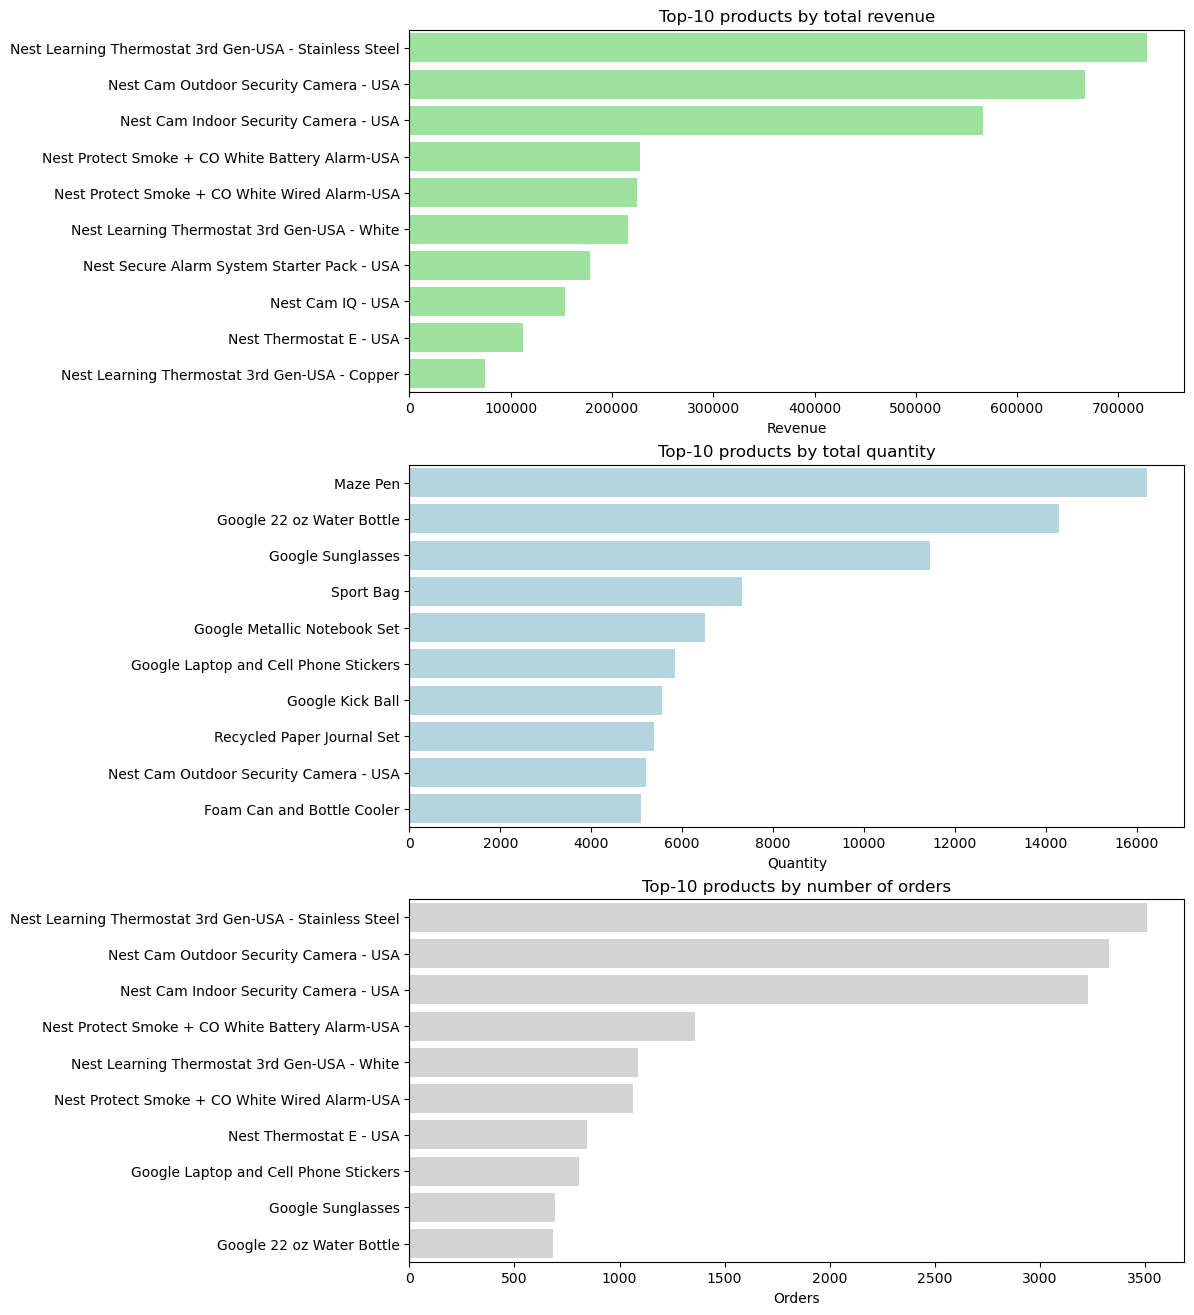

In [32]:
# Top-10 products
top_products_by_revenue = sales.groupby('product_description', as_index=False)['revenue'].sum() \
    .sort_values('revenue', ascending=False) \
    .head(10)

top_products_by_quantity = sales.groupby('product_description', as_index=False)['quantity'].sum() \
    .sort_values('quantity', ascending=False) \
    .head(10)

top_products_by_orders = sales.groupby('product_description', as_index=False)['transaction_id'].nunique() \
    .sort_values('transaction_id', ascending=False) \
    .head(10)

fig, axs = plt.subplots(3, 1, figsize=(10,16))

ax1 = sns.barplot(data=top_products_by_revenue, x='revenue', y='product_description', color='lightgreen', ax=axs[0])
ax1.set(title='Top-10 products by total revenue', xlabel='Revenue', ylabel='')

ax2 = sns.barplot(data=top_products_by_quantity, x='quantity', y='product_description', color='lightblue', ax=axs[1])
ax2.set(title='Top-10 products by total quantity', xlabel='Quantity', ylabel='')

ax3 = sns.barplot(data=top_products_by_orders, x='transaction_id', y='product_description', color='lightgrey', ax=axs[2])
ax3.set(title='Top-10 products by number of orders', xlabel='Orders', ylabel='');


- **Top-10 products by revenue include products from just one category - "Nest-USA",
    and top-3 of them 3x+ revenue than other products**
- **Top-10 products by total quantity of items sold include just one product from the "Nest-USA" category,
    and all other products are pens, water bottles, bags, notebooks, etc. (cheap products that customers buy several at a time)**
- **Top-10 products by number of orders include half of the top-10 products by revenue ("Nest-USA" category),
    other products are cheap ones like stickers, sunglasses, water bottles**
    

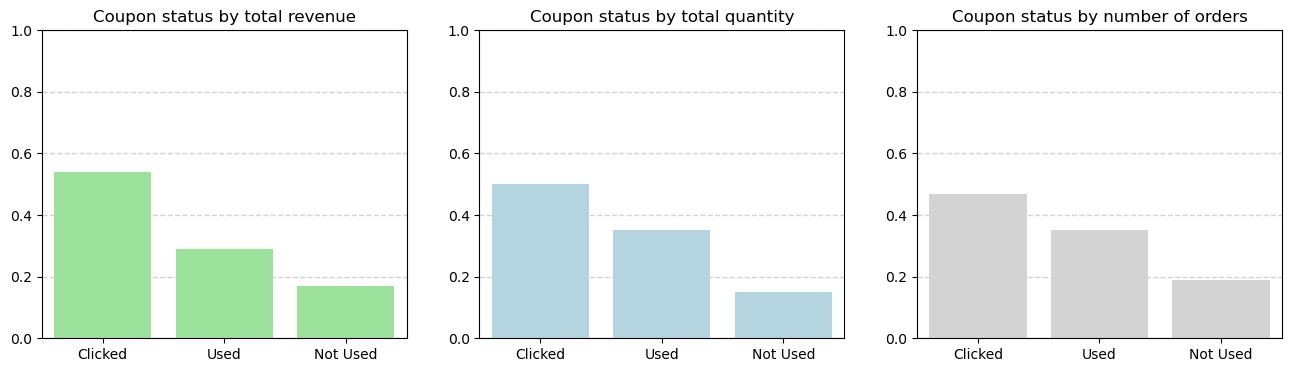

In [33]:
# Coupons distribution by revenue
coupons_dist_revenue = sales.groupby('coupon_status', as_index=False)['revenue'].sum() \
    .sort_values('revenue', ascending=False)

coupons_dist_revenue['total_revenue'] = coupons_dist_revenue['revenue'].sum()
coupons_dist_revenue['share'] = round(coupons_dist_revenue['revenue'] / coupons_dist_revenue['total_revenue'], 2)

# Coupons distribution by quantity
coupons_dist_quantity = sales.groupby('coupon_status', as_index=False)['quantity'].sum() \
    .sort_values('quantity', ascending=False)

coupons_dist_quantity['total_quantity'] = coupons_dist_quantity['quantity'].sum()
coupons_dist_quantity['share'] = round(coupons_dist_quantity['quantity'] / coupons_dist_quantity['total_quantity'], 2)

# Coupons distribution by orders
coupons_dist_orders = sales.groupby('coupon_status', as_index=False)['transaction_id'].nunique() \
    .sort_values('transaction_id', ascending=False)

coupons_dist_orders['total_orders'] = coupons_dist_orders['transaction_id'].sum()
coupons_dist_orders['share'] = round(coupons_dist_orders['transaction_id'] / coupons_dist_orders['total_orders'], 2)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(16,4))

ax1 = sns.barplot(data=coupons_dist_revenue, y='share', x='coupon_status', color='lightgreen', ax=axs[0])
ax1.set(title='Coupon status by total revenue', ylabel='', xlabel='')
ax1.set_axisbelow(True)
ax1.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)
ax1.set_ylim(0, 1)

ax2 = sns.barplot(data=coupons_dist_quantity, y='share', x='coupon_status', color='lightblue', ax=axs[1])
ax2.set(title='Coupon status by total quantity', ylabel='', xlabel='')
ax2.set_axisbelow(True)
ax2.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)
ax2.set_ylim(0, 1)

ax3 = sns.barplot(data=coupons_dist_orders, y='share', x='coupon_status', color='lightgrey', ax=axs[2])
ax3.set(title='Coupon status by number of orders', ylabel='', xlabel='');
ax3.set_axisbelow(True)
ax3.grid(axis='y', color='lightgrey', linestyle='dashed', linewidth=1)
ax3.set_ylim(0, 1);


- The distribution of coupon usage is almost equal among revenue, total quantity, and number of orders

### Summary

1. The customers can be divided into 4 segments: standard, silver, gold, and premium.
    Standard and silver customers generate the most revenue, because there are just not enough premium customers (just 5).
    
    Looks like it is a good idea to acquire more premium customers using specific marketing campaigns,
    and at the same time not lose the standard and silver customers.
    
2. Many categories do not generate almost any revenue.
    The most sellable category that generates the most revenue is "Nest-USA".

3. In most cases, there are no big differences between men's and women's purchasing behavior.
    However, there are more female customers in total, and thus they generate more revenue,
    
4. Customers tend to "click" on a coupon code, but not use it.
    This might be a product problem, 
    but also it might be because customers try to use an old coupon that does not work anymore.
    
5. Average MAU is ~200 customers

6. CAC (customer acquisition cost) grew more than twice since the beginning of the year

7. There is a trend in growing revenue, profit, CAC, orders per customer,
    however, ARPU and AOV are decreasing in December 2019

Now let's try to predict customers' churn to understand how long our customers purchase in the store.


## Churn prediction - survival analysis

Now let's try to predict churn.
**One of the best methods of churn prediction is using survival analysis**.

Survival analysis consists of different regression models, which can be used to predict "time-to-event", or customer's tenure.

First of all, let's plot the distribution of tenure from the initial dataset:

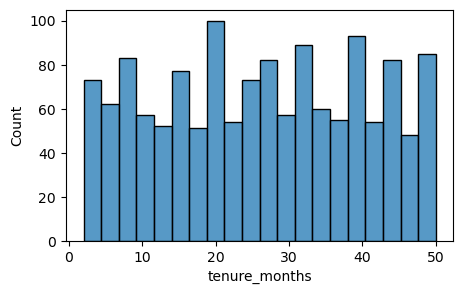

In [34]:
initial_tenure = sales.groupby(['customer_id'], as_index=False)['tenure_months'].min()

ax = plt.figure(figsize=(5,3))
ax = sns.histplot(initial_tenure, x='tenure_months', bins=20);

As I said at the beginning of the EDA, this tenure looks totally unrealistic, 
so let's calculate it ourselves.

We also need to create a "churn" column with values 1/0, indicating if customer is considered churned or not.

Let's plot the distribution of number of purchases per customer first to understand what we are working with:

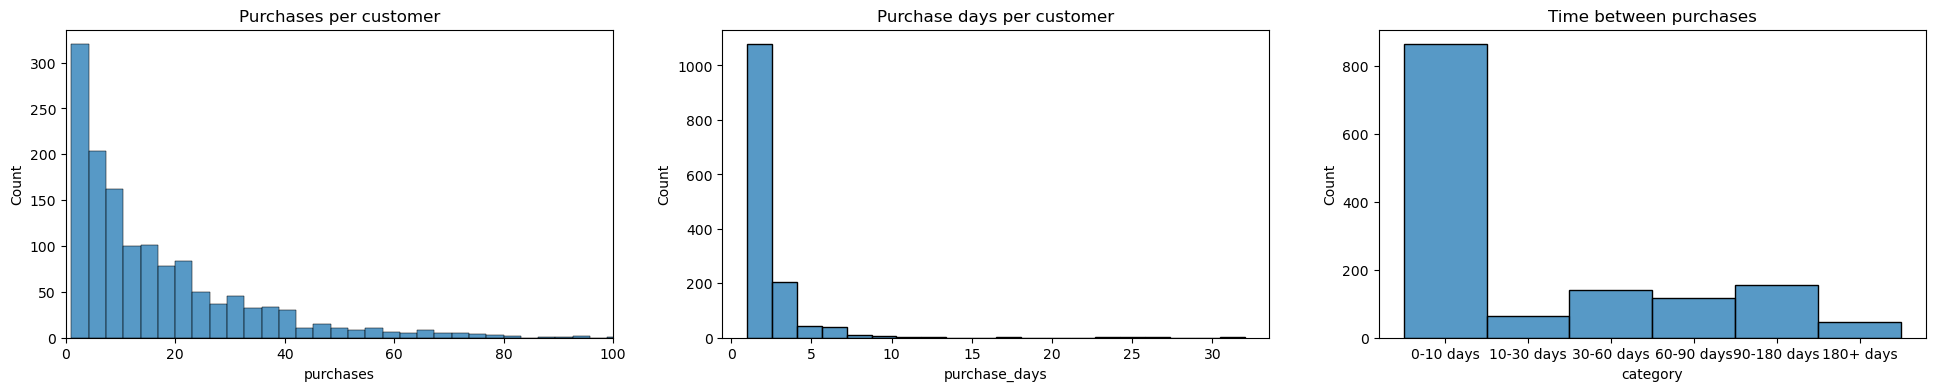

In [35]:
# Purchases per customer
purchases_per_customer = sales.groupby(['customer_id'], as_index=False).agg({
    'transaction_date':'nunique',
    'transaction_id':'nunique'
}) \
    .rename(columns={'transaction_date':'purchase_days', 'transaction_id':'purchases'})


# Days between purchases
transactions = sales[['customer_id','transaction_date']].groupby(['customer_id','transaction_date'], as_index=False).count() \
    .sort_values(['customer_id', 'transaction_date'], ascending=[True, True])

# Merging number of purchases with customers
transactions = transactions.merge(purchases_per_customer, on='customer_id', how='left')

# Calculating next purchase for each purchase
transactions['next_transaction_date'] = transactions.sort_values('transaction_date', ascending=True) \
    .groupby(['customer_id'])['transaction_date'].shift(-1)

# For customers who only have 1 purchase, next purchase date = first/only purchase date
transactions.loc[transactions['purchase_days'] == 1, 'next_transaction_date'] = transactions['transaction_date']

# Calculating difference between purchases in days
transactions['diff'] = (transactions['next_transaction_date'] - transactions['transaction_date']).dt.days

# Dropping NaNs
transactions.dropna(inplace=True)

# Calculating average difference in days for each customer
diff_between_purchases = transactions.groupby(['customer_id','purchase_days','purchases'], as_index=False)['diff'].mean() \
    .rename(columns={'diff':'avg_days_between_purchases'}) \
    .sort_values('avg_days_between_purchases')

# Splitting customers into categories based on their average difference between purchases
diff_between_purchases.loc[(diff_between_purchases['avg_days_between_purchases'] < 10), 'category'] = '0-10 days'
diff_between_purchases.loc[(diff_between_purchases['avg_days_between_purchases'] >= 10) & (diff_between_purchases['avg_days_between_purchases'] < 30), 'category'] = '10-30 days'
diff_between_purchases.loc[(diff_between_purchases['avg_days_between_purchases'] >= 30) & (diff_between_purchases['avg_days_between_purchases'] < 60), 'category'] = '30-60 days'
diff_between_purchases.loc[(diff_between_purchases['avg_days_between_purchases'] >= 60) & (diff_between_purchases['avg_days_between_purchases'] < 90), 'category'] = '60-90 days'
diff_between_purchases.loc[(diff_between_purchases['avg_days_between_purchases'] >= 90) & (diff_between_purchases['avg_days_between_purchases'] < 180), 'category'] = '90-180 days'
diff_between_purchases.loc[(diff_between_purchases['avg_days_between_purchases'] >= 180), 'category'] = '180+ days'


# Plotting
fig, axs = plt.subplots(1,3, figsize=(24,4))
ax1 = sns.histplot(purchases_per_customer, x='purchases', bins=100, ax=axs[0])
ax1.set(title='Purchases per customer')
ax1.set_xlim(0, 100)

ax2 = sns.histplot(purchases_per_customer, x='purchase_days', bins=20, ax=axs[1])
ax2.set(title='Purchase days per customer')

ax3 = sns.histplot(diff_between_purchases, x='category', ax=axs[2])
ax3.set(title='Time between purchases');


- Looks like **most customers have only 1-2 purchases**.
- Most customers **either purchase frequently or rarely (once every 1-6 months)**, 
    however, **after 6 months the number of customers is the smallest**.

Unfortunately, we don't have any additional data about customers' behavior in the store.

So, looks like in this project the best idea is to define churn like this:
- **If a customer does not have any purchases for more than 90 days, he/she is considered to be churned**

Tenure will be calculated like this:
- As maximum date in the data is 2019-12-31, I'll consider **2020-01-01 as "today date"**
- For customers who purchased **less than 3 months before 2020-01-01, tenure = (today_date - min_purchase_date)**
- For customers who purchased **more than 3 months before 2020-01-01, tenure = (max_purchase_date - min_purchase_date)**


In [36]:
# Calculating tenure correctly
customers_correct_tenure = sales.groupby(['customer_id','tenure_months'], as_index=False).agg({'transaction_date':['min','max']})
customers_correct_tenure.columns = ['customer_id', 'tenure_months', 'transaction_date_min', 'transaction_date_max']

customers_correct_tenure['today_date'] = datetime(2020, 1, 1)
customers_correct_tenure['churn_date'] = np.where((customers_correct_tenure['today_date'] - customers_correct_tenure['transaction_date_max']).dt.days > 90,
                                                  customers_correct_tenure['transaction_date_max'],
                                                  customers_correct_tenure['today_date'])

# Defining churn
customers_correct_tenure['churn'] = np.where(customers_correct_tenure['churn_date'] == customers_correct_tenure['today_date'], 0, 1)
# customers_correct_tenure['correct_tenure'] = (customers_correct_tenure['churn_date'] - customers_correct_tenure['transaction_date_min']).dt.days // 30 
customers_correct_tenure['correct_tenure'] = round((customers_correct_tenure['churn_date'] - customers_correct_tenure['transaction_date_min']) / np.timedelta64(1,'M'), 2)

customers_correct_tenure


,customer_id,tenure_months,transaction_date_min,transaction_date_max,today_date,churn_date,churn,correct_tenure
0,12347,20,2019-03-24,2019-11-02,2020-01-01,2020-01-01,0,9.30
1,12348,39,2019-06-22,2019-10-19,2020-01-01,2020-01-01,0,6.34
2,12350,25,2019-12-14,2019-12-14,2020-01-01,2020-01-01,0,0.59
3,12356,31,2019-09-15,2019-09-15,2020-01-01,2019-09-15,1,0.00
4,12359,41,2019-08-23,2019-08-23,2020-01-01,2019-08-23,1,0.00
...,...,...,...,...,...,...,...,...
1382,18250,15,2019-12-13,2019-12-13,2020-01-01,2020-01-01,0,0.62
1383,18256,45,2019-07-05,2019-07-05,2020-01-01,2019-07-05,1,0.00
1384,18259,5,2019-04-05,2019-04-05,2020-01-01,2019-04-05,1,0.00
1385,18260,43,2019-06-22,2019-10-05,2020-01-01,2020-01-01,0,6.34


1    0.625811
0    0.374189
Name: churn, dtype: float64

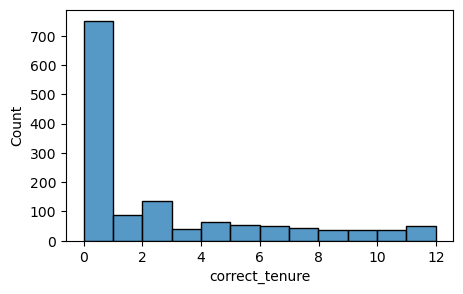

In [37]:
# Plotting new tenure
ax = plt.figure(figsize=(5,3))
ax = sns.histplot(customers_correct_tenure, x='correct_tenure', bins=12);

customers_correct_tenure['churn'].value_counts(normalize=True)

Good, this tenure looks a lot more natural than before!

Now let's merge new tenure and churn columns with the main dataset:

In [38]:
sales = sales.merge(
    customers_correct_tenure[['customer_id','correct_tenure','churn']],
    how='left',
    on='customer_id'
)

sales.head()

,product_transaction_id,transaction_id,product_sku,price_id,quantity,discount_id,coupon_status,transaction_date,customer_id,delivery_charges,...,tenure_months,revenue,segment,transaction_month,transaction_month_name,acquisition_month,acquisition_date,acquisition_month_name,correct_tenure,churn
0,1,16679,GGOENEBJ079499,47,1,4.0,Used,2019-01-01,17850,6.5,...,12,158.6729,gold,2019-01-01,Jan 19,2019-01-01,2019-01-01,Jan 19,0.82,1
1,2,16680,GGOENEBJ079499,47,1,4.0,Used,2019-01-01,17850,6.5,...,12,158.6729,gold,2019-01-01,Jan 19,2019-01-01,2019-01-01,Jan 19,0.82,1
2,3,16681,GGOEGFKQ020399,31,1,7.0,Used,2019-01-01,17850,6.5,...,12,8.5295,gold,2019-01-01,Jan 19,2019-01-01,2019-01-01,Jan 19,0.82,1
3,4,16682,GGOEGAAB010516,4,5,1.0,Not Used,2019-01-01,17850,6.5,...,12,109.9270,gold,2019-01-01,Jan 19,2019-01-01,2019-01-01,Jan 19,0.82,1
4,5,16682,GGOEGBJL013999,22,1,16.0,Used,2019-01-01,17850,6.5,...,12,24.0230,gold,2019-01-01,Jan 19,2019-01-01,2019-01-01,Jan 19,0.82,1


Now let's create a dataset with all the data we need for further work, 
including new metrics like total number of unique products purchased by a customer, 
number of unique categories purchased by a customer, etc.

Also I'll calculate the most frequent coupon_code, coupon_status, and category for each customer.

In [39]:
data_for_prediction = sales[['customer_id','acquisition_month','acquisition_date','quantity','product_sku','transaction_id','coupon_status','delivery_charges',
                                  'price','revenue','category_id','coupon_code','gender','location','segment','correct_tenure',
                                  'churn']].copy()

customers_for_prediction = data_for_prediction.groupby('customer_id', as_index=False).apply(lambda group: pd.Series({
    'acquisition_month': group['acquisition_month'].min(),
    'acquisition_date': group['acquisition_date'].min(),
    'total_quantity_of_products': group['quantity'].sum(),
    'unique_products': group['product_sku'].nunique(),
    'most_common_coupon_status': group['coupon_status'].mode()[0],
    'total_delivery_charges': group['delivery_charges'].sum(),
    'total_price': group['price'].sum(),
    'total_revenue': group['revenue'].sum(),
    'unique_categories': group['category_id'].nunique(),
    'most_common_category': group['category_id'].mode()[0],
    'unique_coupons_used': group['coupon_code'].nunique(),
    'most_common_coupon_code': group['coupon_code'].mode()[0],
    'gender': group['gender'].min(),
    'location': group['location'].min(),
    'segment': group['segment'].min(),
    'correct_tenure': group['correct_tenure'].min(),
    'churn': group['churn'].min()
}))

customers_for_prediction.head()


,customer_id,acquisition_month,acquisition_date,total_quantity_of_products,unique_products,most_common_coupon_status,total_delivery_charges,total_price,total_revenue,unique_categories,most_common_category,unique_coupons_used,most_common_coupon_code,gender,location,segment,correct_tenure,churn
0,12347,2019-03-01,2019-03-24,345,43,Clicked,692.49,3760.89,15734.79612,10,1,13,ELEC20,M,New York,gold,9.30,0
1,12348,2019-06-01,2019-06-22,170,20,Used,191.15,312.86,1298.00972,6,2,10,EXTRA30,M,California,silver,6.34,0
2,12350,2019-12-01,2019-12-14,23,12,Clicked,140.87,1515.24,1906.38928,5,3,5,SALE30,M,California,silver,0.59,0
3,12356,2019-09-01,2019-09-15,55,32,Clicked,631.49,1234.74,1991.72226,7,3,6,SALE30,F,Chicago,silver,0.00,1
4,12359,2019-08-01,2019-08-23,125,19,Clicked,120.00,247.47,1015.22640,4,3,5,SALE20,M,New York,silver,0.00,1


In [40]:
from lifelines import KaplanMeierFitter
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from lifelines.utils import k_fold_cross_validation


# Adding number of purchases and averate time between purchases for each customer
customers_for_prediction = customers_for_prediction.merge(diff_between_purchases[['customer_id','purchases','avg_days_between_purchases']], on='customer_id', how='left')
customers_for_prediction.drop(columns='customer_id', inplace=True)

# Dividing acquisition month into year and month, and acquisition date into number of days since 2019-01-01
customers_for_prediction['acq_dayofyear'] = customers_for_prediction['acquisition_date'].dt.dayofyear
customers_for_prediction.drop(columns=['acquisition_month','acquisition_date'], inplace=True)

# Frequency encoding (changing the values of a categorical variable to frequencies of these values)
coupon_code_frequency_mapping = customers_for_prediction['most_common_coupon_code'].value_counts().to_dict()
customers_for_prediction['most_common_coupon_code'] = customers_for_prediction['most_common_coupon_code'].map(coupon_code_frequency_mapping)

categories_frequency_mapping = customers_for_prediction['most_common_category'].value_counts().to_dict()
customers_for_prediction['most_common_category'] = customers_for_prediction['most_common_category'].map(categories_frequency_mapping)

# Dummy encoding
columns_dummy = customers_for_prediction[['most_common_coupon_status','gender','location','segment']]
columns_dummy = pd.get_dummies(columns_dummy, drop_first=True)
customers_for_prediction.drop(columns=['most_common_coupon_status','gender','location','segment'], inplace=True)
customers_for_prediction = pd.concat([customers_for_prediction, columns_dummy], axis=1)

customers_for_prediction

,total_quantity_of_products,unique_products,total_delivery_charges,total_price,total_revenue,unique_categories,most_common_category,unique_coupons_used,most_common_coupon_code,correct_tenure,...,most_common_coupon_status_Not Used,most_common_coupon_status_Used,gender_M,location_Chicago,location_New Jersey,location_New York,location_Washington DC,segment_premium,segment_silver,segment_standard
0,345,43,692.49,3760.89,15734.79612,10,540,13,151,9.30,...,0,0,1,0,0,1,0,0,0,0
1,170,20,191.15,312.86,1298.00972,6,99,10,29,6.34,...,0,1,1,0,0,0,0,0,1,0
2,23,12,140.87,1515.24,1906.38928,5,686,5,222,0.59,...,0,0,1,0,0,0,0,0,1,0
3,55,32,631.49,1234.74,1991.72226,7,686,6,222,0.00,...,0,0,0,1,0,0,0,0,1,0
4,125,19,120.00,247.47,1015.22640,4,686,5,228,0.00,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382,172,16,320.80,754.49,3245.06770,4,686,5,222,0.62,...,0,1,1,1,0,0,0,0,1,0
1383,4,4,25.00,49.56,83.35360,2,686,2,200,0.00,...,0,0,1,0,0,0,0,0,0,1
1384,2,2,13.00,27.98,46.01640,2,21,2,35,0.00,...,0,0,0,0,0,0,0,0,0,1
1385,80,29,316.73,1082.85,2397.04688,10,686,14,228,6.34,...,0,0,1,0,0,1,0,0,1,0


**There are too many features, which can also be highly correlated between each other,
which creates a multicollinearity problem**.

The easiest solution is to calculate the correlation between all features,
and in each pair of features drop one of them if Pearson's correlation between them is > threshold (I'll use 0.7):


Number of categories to delete: 9
Categories to delete: ['purchases', 'total_price', 'most_common_coupon_code', 'total_delivery_charges', 'segment_standard', 'total_revenue', 'unique_categories', 'unique_products', 'unique_coupons_used']



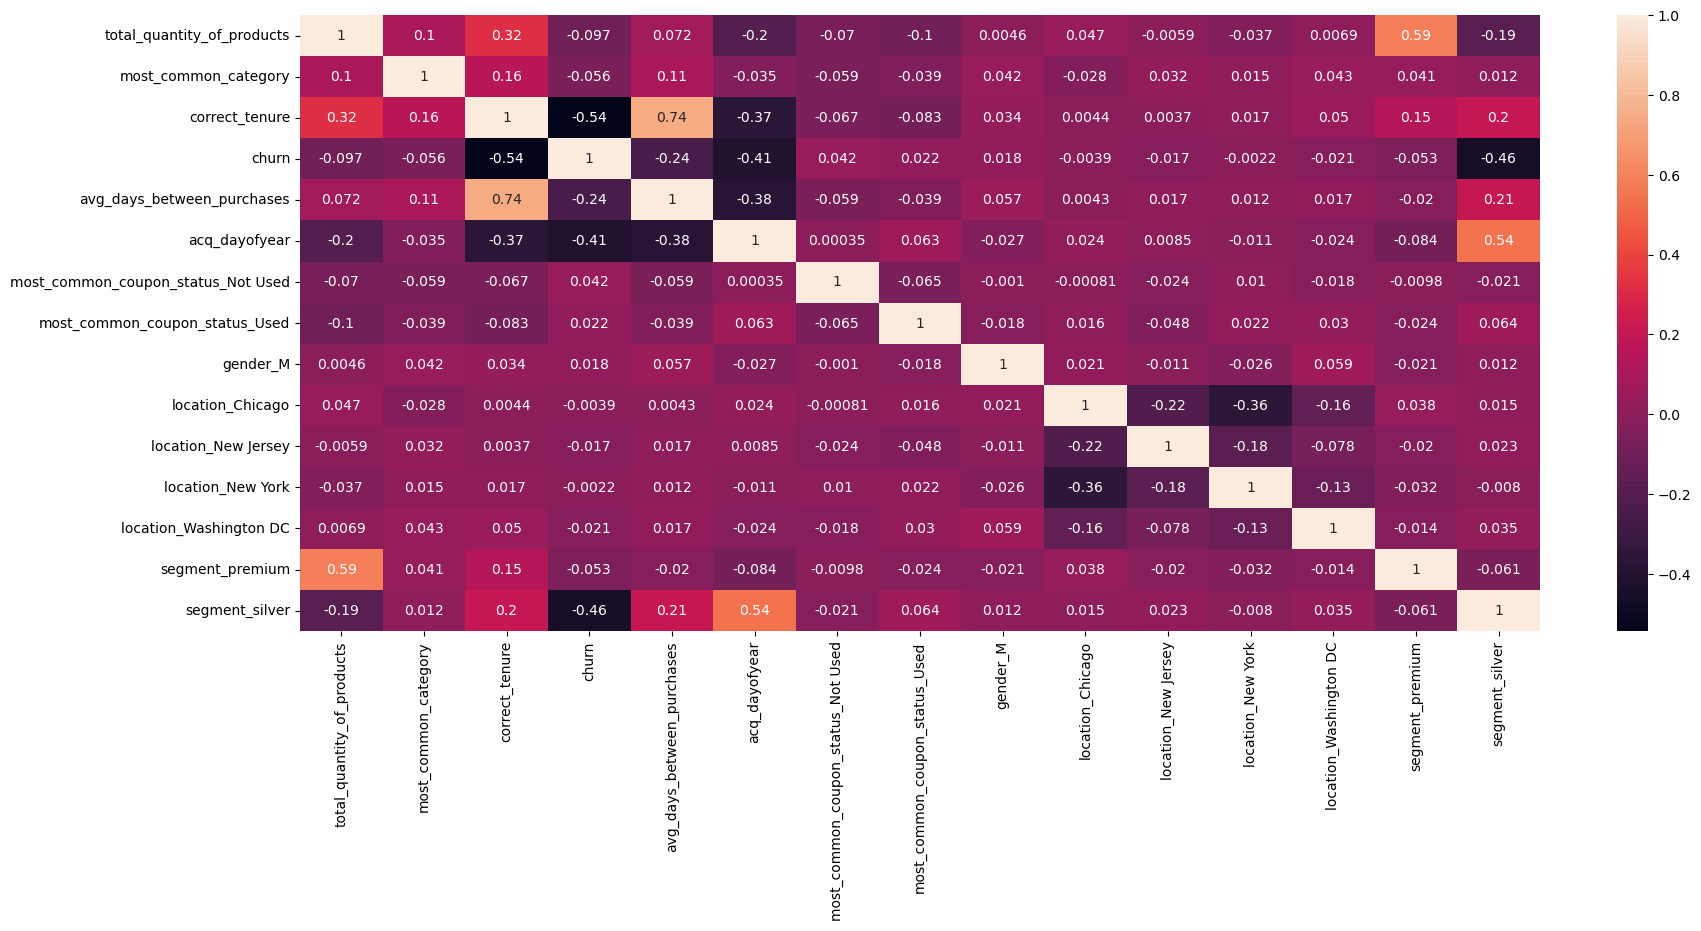

In [41]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(customers_for_prediction.drop(columns=['correct_tenure','churn']), 0.7)
print(f'''
Number of categories to delete: {len(set(corr_features))}
Categories to delete: {list(corr_features)}
''')

customers_for_prediction.drop(columns=list(corr_features), inplace=True)

plt.subplots(figsize=(20,8))
sns.heatmap(customers_for_prediction.corr(), annot=True);


Now I'll fit the Cox Proportional Hazard Model and use 5-fold cross validation to ensure the model fits correctly.

**Why Cox Proportional Hazard Model?**

This is a more or less universal semi-parametric model that, unlike other parametric models, 
does not have any requirements about tenure's distribution.


In [42]:
from lifelines import CoxPHFitter
from sklearn.decomposition import PCA

# Model fitting
cph = CoxPHFitter()
cph.fit(customers_for_prediction, duration_col='correct_tenure', event_col='churn')
cph.print_summary()

# 5-fold cross validation
scores = k_fold_cross_validation(cph,
                                 customers_for_prediction,
                                 duration_col='correct_tenure',
                                 event_col='churn',
                                 k=5,
                                 scoring_method='concordance_index')

print(f'Mean concordance index = {sum(scores) / len(scores)}')


<lifelines.CoxPHFitter: fitted with 1387 total observations, 519 right-censored observations>
             duration col = 'correct_tenure'
                event col = 'churn'
      baseline estimation = breslow
   number of observations = 1387
number of events observed = 868
   partial log-likelihood = -5316.95
         time fit was run = 2024-02-20 15:15:46 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
total_quantity_of_products          -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
most_common_category                -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
avg_days_between_purchases          -0.02       0.98       0.00            -0.03            -0.02                 0.97                 0.98
acq_dayofyear                       -0.00       1.00       0.00            -0.01            -0.00                 0.99                 1.00
most_common_coupon_status_Not Used   0.16       1.18       0.20            -0.23             0.55                 0.80                 1.73
most_common_coupon_status_Used       0.17       1.19       0.10            -0.02             0.36                 0.98                 1.44
gender_M                             0.11       1.12       0.07            -0.03             0.25                 0.97                 1.29
location_Chicago                    -0.01       0.99       0.09            -0.18             0.16                 0.84                 1.17
location_New Jersey                  0.18       1.20       0.13            -0.07             0.42                 0.93                 1.53
location_New York                   -0.06       0.94       0.09            -0.24             0.12                 0.78                 1.13
location_Washington DC              -0.15       0.86       0.17            -0.47             0.18                 0.62                 1.20
segment_premium                      0.87       2.39       1.09            -1.27             3.01                 0.28                20.26
segment_silver                      -0.71       0.49       0.10            -0.91            -0.51                 0.40                 0.60

                                     cmp to      z      p   -log2(p)
covariate                                                           
total_quantity_of_products             0.00  -9.25 <0.005      65.30
most_common_category                   0.00  -2.23   0.03       5.29
avg_days_between_purchases             0.00 -17.00 <0.005     212.88
acq_dayofyear                          0.00  -9.43 <0.005      67.78
most_common_coupon_status_Not Used     0.00   0.82   0.41       1.27
most_common_coupon_status_Used         0.00   1.72   0.09       3.54
gender_M                               0.00   1.60   0.11       3.19
location_Chicago                       0.00  -0.09   0.93       0.10
location_New Jersey                    0.00   1.42   0.16       2.68
location_New York                      0.00  -0.65   0.52       0.95
location_Washington DC                 0.00  -0.88   0.38       1.40
segment_premium                        0.00   0.80   0.42       1.24
segment_silver                         0.00  -6.99 <0.005      38.39
---
Concordance = 0.88
Partial AIC = 10659.90
log-likelihood ratio test = 947.74 on 13 df
-log2(p) of ll-ratio test = 642.92

Mean concordance index = 0.8794740324798411


**Coefficients**

Features total_quantity_of_products, most_common_category, avg_days_between_purchases, acq_dayofyear, and segment_silver 
have coefficients with a p-value < 0.05, which means that there is a statistically significant relation
between the feature and the target variable.

**Concordance index**

This measure evaluates the accuracy of the ranking of predicted time. 
It is in fact a generalization of AUC, another common loss function, and is interpreted similarly:

- 0.5 is the expected result from random predictions,
- 1.0 is perfect concordance and,
- 0.0 is perfect anti-concordance (multiply predictions with -1 to get 1.0)

In our case it is 0.88, which is very good.

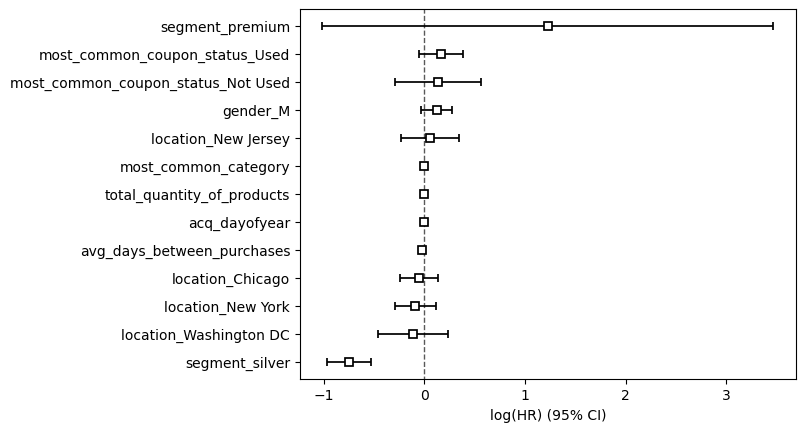

In [43]:
cph.plot();


**Now let's predict expected remaining tenure for each customer:**

In [44]:
# Filtering down to just censored subjects to predict remaining survival
censored_subjects = customers_for_prediction.loc[customers_for_prediction['churn'] == 0]
censored_subjects_last_obs = censored_subjects['correct_tenure']

# Predicting mean remaining life
predicted_tenure = cph.predict_expectation(censored_subjects, conditional_after=censored_subjects_last_obs)
predicted_tenure.value_counts()


11.990000    138
5.845967       1
10.072924      1
2.929460       1
5.815955       1
            ... 
3.187935       1
6.821813       1
4.502951       1
11.431228      1
8.331760       1
Length: 382, dtype: int64

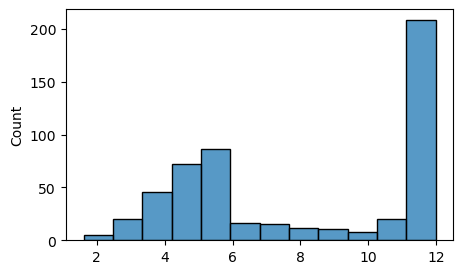

In [45]:
ax = plt.figure(figsize=(5,3))
ax = sns.histplot(predicted_tenure, bins=12);

In [46]:
# Joining predicted tenure to customers
predicted_tenure = pd.Series(round(predicted_tenure, 2), name='remaining_expected_tenure')
customers_correct_tenure = customers_correct_tenure.merge(predicted_tenure, how='left', left_index=True, right_index=True) \
    .fillna(0)

# Calculating full tenure (tenure + predicted tenure)
customers_correct_tenure['full_tenure'] = customers_correct_tenure['correct_tenure'] + customers_correct_tenure['remaining_expected_tenure']
customers_correct_tenure.head()


,customer_id,tenure_months,transaction_date_min,transaction_date_max,today_date,churn_date,churn,correct_tenure,remaining_expected_tenure,full_tenure
0,12347,20,2019-03-24,2019-11-02,2020-01-01,2020-01-01,0,9.30,11.99,21.29
1,12348,39,2019-06-22,2019-10-19,2020-01-01,2020-01-01,0,6.34,11.44,17.78
2,12350,25,2019-12-14,2019-12-14,2020-01-01,2020-01-01,0,0.59,5.16,5.75
3,12356,31,2019-09-15,2019-09-15,2020-01-01,2019-09-15,1,0.00,0.00,0.00
4,12359,41,2019-08-23,2019-08-23,2020-01-01,2019-08-23,1,0.00,0.00,0.00


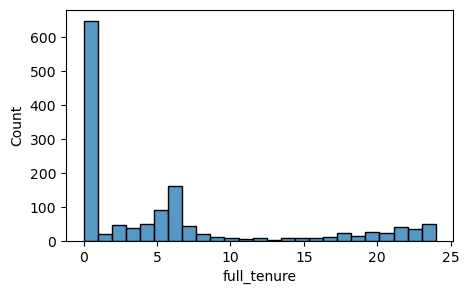

In [47]:
ax = plt.figure(figsize=(5,3))
ax = sns.histplot(customers_correct_tenure['full_tenure'], bins=25);

**Now it's interesting to use full customer's tenure to calculate LTV**.

This can be done by calculating revenue per month for each customer and multiplying it by their full tenure

In [48]:
# Creating a dataframe to calculate total LTV 
tenure_ltv = sales[['customer_id','correct_tenure','revenue']] \
    .groupby(['customer_id','correct_tenure'], as_index=False)['revenue'] \
    .sum() 

tenure_ltv = tenure_ltv.merge(customers_correct_tenure[['customer_id','full_tenure']], on='customer_id', how='left')

tenure_ltv['revenue_per_month'] = tenure_ltv[tenure_ltv['correct_tenure'] != 0]['revenue'] / tenure_ltv[tenure_ltv['correct_tenure'] != 0]['correct_tenure']
tenure_ltv['ltv_full_tenure'] = tenure_ltv['revenue'] + (tenure_ltv['full_tenure'] - tenure_ltv['correct_tenure']) * tenure_ltv['revenue_per_month']
tenure_ltv.loc[tenure_ltv['correct_tenure'] == 0, ['revenue_per_month','ltv_full_tenure']] = tenure_ltv['revenue']

tenure_ltv.head()

,customer_id,correct_tenure,revenue,full_tenure,revenue_per_month,ltv_full_tenure
0,12347,9.30,15734.79612,21.29,1691.913561,36020.839720
1,12348,6.34,1298.00972,17.78,204.733394,3640.159751
2,12350,0.59,1906.38928,5.75,3231.168271,18579.217559
3,12356,0.00,1991.72226,0.00,1991.722260,1991.722260
4,12359,0.00,1015.22640,0.00,1015.226400,1015.226400


**Now I'll use KMeans to split the customers into clusters based on their LTV:**

In [49]:
kmeans_ltv_tenure = KMeans(n_clusters=4)
kmeans_ltv_tenure.fit(tenure_ltv[['revenue','ltv_full_tenure']])
tenure_ltv['cluster'] = kmeans_ltv_tenure.labels_

tenure_ltv['cluster'].value_counts()


0    1211
3     156
2      17
1       3
Name: cluster, dtype: int64

In [50]:
# Grouping by clusters
tenure_ltv_grouped = tenure_ltv.groupby('cluster', as_index=False)['ltv_full_tenure'].mean()
tenure_ltv_grouped 


,cluster,ltv_full_tenure
0,0,4262.300153
1,1,591862.817022
2,2,130541.521928
3,3,33385.415617


In [51]:
# Ranking the clusters based on recency, frequency, and monetary
tenure_ltv_grouped['ltv_rank'] = tenure_ltv_grouped['ltv_full_tenure'].rank(ascending=False)

# Assigning segments based on rankings
def assign_group(row, sorted_ranks):
    if row['ltv_rank'] == sorted_ranks[0]:
        return 'top_ltv'
    elif row['ltv_rank'] == sorted_ranks[1]:
        return 'high_ltv'
    elif row['ltv_rank'] == sorted_ranks[2]:
        return 'medium_ltv'
    elif row['ltv_rank'] == sorted_ranks[3]:
        return 'low_ltv'

# Sorting the total ranks
sorted_ranks = sorted(tenure_ltv_grouped['ltv_rank'].unique())

# Apply the function with sorted ranks as argument
tenure_ltv_grouped['segment_ltv_based_on_tenure'] = tenure_ltv_grouped.apply(assign_group, args=(sorted_ranks,), axis=1)

# Merge the group information back to the original DataFrame
tenure_ltv = pd.merge(tenure_ltv, tenure_ltv_grouped[['cluster', 'segment_ltv_based_on_tenure']], on='cluster', how='left')

tenure_ltv.head()


,customer_id,correct_tenure,revenue,full_tenure,revenue_per_month,ltv_full_tenure,cluster,segment_ltv_based_on_tenure
0,12347,9.30,15734.79612,21.29,1691.913561,36020.839720,3,medium_ltv
1,12348,6.34,1298.00972,17.78,204.733394,3640.159751,0,low_ltv
2,12350,0.59,1906.38928,5.75,3231.168271,18579.217559,0,low_ltv
3,12356,0.00,1991.72226,0.00,1991.722260,1991.722260,0,low_ltv
4,12359,0.00,1015.22640,0.00,1015.226400,1015.226400,0,low_ltv


In [52]:
tenure_ltv.groupby('segment_ltv_based_on_tenure', as_index=False)['ltv_full_tenure'].mean()

,segment_ltv_based_on_tenure,ltv_full_tenure
0,high_ltv,130541.521928
1,low_ltv,4262.300153
2,medium_ltv,33385.415617
3,top_ltv,591862.817022


## LTV prediction - BG/NBD and Gamma-Gamma

There is a better approach to predict LTV, which is using the BD/NBD and Gamma-Gamma models.

- The BG/NBD model is used to predict the number of purchases in the next N days/months/etc.
- The Gamma-Gamma model is used to predict the LTV based on the predicted number of purchases in the next N days/months/etc.

Both of these models require a certain shape of data, which is very close to a classic RFM (recency, frequency, monetary).
However, the RFM-styled shape of data differs from the classic RFM that I used for customers' segmentation at the beginning
of this project.

For these models, the following nomenclature is used:

- **frequency** represents the number of repeat purchases the customer has made. 
    This means that it’s one less than the total number of purchases. 
    This is actually slightly wrong. 
    It’s the count of time periods the customer had a purchase in. 
    So if using days as units, then it’s the count of days the customer had a purchase on.
- **T** represents the age of the customer in whatever time units chosen (weekly, in the above dataset). 
    This is equal to the duration between a customer’s first purchase and the end of the period under study.
- **recency** represents the age of the customer when they made their most recent purchases. 
    This is equal to the duration between a customer’s first purchase and their latest purchase. 
    (Thus if they have made only 1 purchase, the recency is 0.)
- **monetary_value** represents the average value of a given customer’s purchases. 
    This is equal to the sum of all a customer’s purchases divided by the total number of purchases. 
    Note that the denominator here is different than the frequency described above.

[lifetimes library docs](https://lifetimes.readthedocs.io/en/latest/Quickstart.html?highlight=calibration_and_holdout_data#the-shape-of-your-data)


In [53]:
from sklearn.metrics import mean_squared_error
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

# Computing the summary data (Recency, Frequency, monetary and tenure)
rfmt = summary_data_from_transaction_data(sales,'customer_id','transaction_date','revenue', include_first_transaction=True) \
    .reset_index()

rfmt


,customer_id,frequency,recency,T,monetary_value
0,12347,3.0,223.0,282.0,5244.932040
1,12348,2.0,119.0,192.0,649.004860
2,12350,1.0,0.0,17.0,1906.389280
3,12356,1.0,0.0,107.0,1991.722260
4,12359,1.0,0.0,130.0,1015.226400
...,...,...,...,...,...
1382,18250,1.0,0.0,18.0,3245.067700
1383,18256,1.0,0.0,179.0,83.353600
1384,18259,1.0,0.0,270.0,46.016400
1385,18260,3.0,105.0,192.0,799.015627


Now I'll create a **calibration dataset, whith basically means splitting the initial RFM-styled data into two periods:
calibration period and holdout period**.

**The calibration period is used to train the model**, and then the accuracy of the model can be evaluated
**by comparing the predicted purchases and actual purchases in the holdout period**.


In [54]:
calibration_period_end = sales['transaction_date'].min() + pd.Timedelta(days=250)

rfmt_calibration = calibration_and_holdout_data(sales,'customer_id', 'transaction_date', calibration_period_end)
rfmt_calibration

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
customer_id,,,,,
12347,0.0,0.0,168.0,2.0,114.0
12348,0.0,0.0,78.0,1.0,114.0
12359,0.0,0.0,16.0,0.0,114.0
12370,1.0,30.0,105.0,0.0,114.0
12377,0.0,0.0,65.0,1.0,114.0
...,...,...,...,...,...
18245,1.0,1.0,66.0,1.0,114.0
18256,0.0,0.0,65.0,0.0,114.0
18259,0.0,0.0,156.0,0.0,114.0


**Now let's fit the model and predict the number of purchases for each customer:**

In [55]:
bg_nbd = BetaGeoFitter()
bg_nbd.fit(rfmt_calibration['frequency_cal'], rfmt_calibration['recency_cal'], rfmt_calibration['T_cal'])

bg_nbd.predict(rfmt_calibration['duration_holdout'], 
               rfmt_calibration['frequency_cal'], 
               rfmt_calibration['recency_cal'], 
               rfmt_calibration['T_cal'])


customer_id
12347    0.249552
12348    0.390496
12359    0.646421
12370    0.452583
12377    0.425499
           ...   
18245    0.520522
18256    0.425499
18259    0.262115
18260    0.685949
18283    0.510449
Length: 1078, dtype: float64

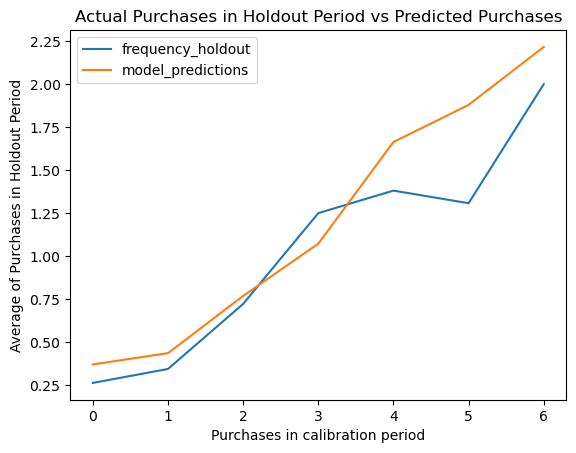

In [56]:
# Plotting actual purchases vs predicted purchases in the holdout period to see if the predictions were close
plot_calibration_purchases_vs_holdout_purchases(bg_nbd, rfmt_calibration);


The prediction is pretty close to actual purchases.

Now let's predict the expected number of purchases in the next year:

In [57]:
# Predicting the number of purchases in the next 365 days for all customers
rfmt['pred_purchases'] = bg_nbd \
    .conditional_expected_number_of_purchases_up_to_time(365, rfmt['frequency'], rfmt['recency'], rfmt['T'])

rfmt

,customer_id,frequency,recency,T,monetary_value,pred_purchases
0,12347,3.0,223.0,282.0,5244.932040,2.428723
1,12348,2.0,119.0,192.0,649.004860,1.911513
2,12350,1.0,0.0,17.0,1906.389280,2.747486
3,12356,1.0,0.0,107.0,1991.722260,0.821185
4,12359,1.0,0.0,130.0,1015.226400,0.646021
...,...,...,...,...,...,...
1382,18250,1.0,0.0,18.0,3245.067700,2.701724
1383,18256,1.0,0.0,179.0,83.353600,0.411733
1384,18259,1.0,0.0,270.0,46.016400,0.209024
1385,18260,3.0,105.0,192.0,799.015627,2.431995


**Now, we can fit the Gamma-Gamma model using the fitted BG/NBD model to predict the LTV itself:**

In [58]:
# Fitting the GammaGamma model
gg_model = GammaGammaFitter()
gg_model.fit(rfmt['frequency'], rfmt['monetary_value'])

# Predicting average expected monetary for each customer
rfmt['predicted_monetary'] = gg_model.conditional_expected_average_profit(rfmt['frequency'], rfmt['monetary_value'])

# Predicting the 12-month LTV
rfmt['ltv_gamma_gamma_predicted_1_year'] = gg_model.customer_lifetime_value(
    bg_nbd,
    rfmt['frequency'],
    rfmt['recency'],
    rfmt['T'],
    rfmt['monetary_value'],
    time = 12, # in months 
    )

# Getting the historical revenue for each customer to calculate full LTV
rfmt = rfmt.merge(tenure_ltv[['customer_id','revenue']], on='customer_id', how='left')

# Calculating full LTV
rfmt['ltv_gamma_gamma'] = rfmt['revenue'] + rfmt['ltv_gamma_gamma_predicted_1_year']
rfmt.drop(columns='ltv_gamma_gamma_predicted_1_year', inplace=True)

rfmt

,customer_id,frequency,recency,T,monetary_value,pred_purchases,predicted_monetary,revenue,ltv_gamma_gamma
0,12347,3.0,223.0,282.0,5244.932040,2.428723,3306.125894,15734.79612,23201.686079
1,12348,2.0,119.0,192.0,649.004860,1.911513,1495.310208,1298.00972,3958.897287
2,12350,1.0,0.0,17.0,1906.389280,2.747486,1904.050321,1906.38928,6800.195360
3,12356,1.0,0.0,107.0,1991.722260,0.821185,1920.630243,1991.72226,3462.348538
4,12359,1.0,0.0,130.0,1015.226400,0.646021,1730.900258,1015.22640,2057.324360
...,...,...,...,...,...,...,...,...,...
1382,18250,1.0,0.0,18.0,3245.067700,2.701724,2164.151206,3245.06770,8714.445314
1383,18256,1.0,0.0,179.0,83.353600,0.411733,1549.840389,83.35360,677.511088
1384,18259,1.0,0.0,270.0,46.016400,0.209024,1542.585891,46.01640,345.886796
1385,18260,3.0,105.0,192.0,799.015627,2.431995,1439.862325,2397.04688,5656.951736


Now I'll use KMeans again to segment the customers by LTV so that I can compare the segments made by:
- predicting LTV based on tenure
- predicting LTV using BG/NBD and Gamma-Gamma models

In [59]:
km_model = KMeans(n_clusters=4)
km_model.fit(rfmt.drop(columns='customer_id'))

# Creating a new column called cluster whose values are the corresponding cluster for each point.
rfmt['cluster'] = km_model.labels_
rfmt

,customer_id,frequency,recency,T,monetary_value,pred_purchases,predicted_monetary,revenue,ltv_gamma_gamma,cluster
0,12347,3.0,223.0,282.0,5244.932040,2.428723,3306.125894,15734.79612,23201.686079,3
1,12348,2.0,119.0,192.0,649.004860,1.911513,1495.310208,1298.00972,3958.897287,2
2,12350,1.0,0.0,17.0,1906.389280,2.747486,1904.050321,1906.38928,6800.195360,2
3,12356,1.0,0.0,107.0,1991.722260,0.821185,1920.630243,1991.72226,3462.348538,2
4,12359,1.0,0.0,130.0,1015.226400,0.646021,1730.900258,1015.22640,2057.324360,2
...,...,...,...,...,...,...,...,...,...,...
1382,18250,1.0,0.0,18.0,3245.067700,2.701724,2164.151206,3245.06770,8714.445314,2
1383,18256,1.0,0.0,179.0,83.353600,0.411733,1549.840389,83.35360,677.511088,2
1384,18259,1.0,0.0,270.0,46.016400,0.209024,1542.585891,46.01640,345.886796,2
1385,18260,3.0,105.0,192.0,799.015627,2.431995,1439.862325,2397.04688,5656.951736,2


In [60]:
# Grouping by clusters
rfmt_grouped = rfmt.groupby('cluster', as_index=False)['ltv_gamma_gamma'] \
                     .agg({'ltv_gamma_gamma':'mean','monetary_value':'count'}) \
                     .rename(columns={'ltv_gamma_gamma':'avg_ltv', 'monetary_value':'customers'})

rfmt_grouped['share_customers'] = (rfmt_grouped['customers'] / rfmt_grouped['customers'].sum())
rfmt_grouped 

,cluster,avg_ltv,customers,share_customers
0,0,12560.244321,313,0.225667
1,1,104467.338812,6,0.004326
2,2,3410.530179,1033,0.744773
3,3,34111.511481,35,0.025234


In [61]:
# Ranking the clusters based on recency, frequency, and monetary
rfmt_grouped['ltv_rank'] = rfmt_grouped['avg_ltv'].rank(ascending=False)

# Assigning segments based on rankings
def assign_group(row, sorted_ranks):
    if row['ltv_rank'] == sorted_ranks[0]:
        return 'top_ltv'
    elif row['ltv_rank'] == sorted_ranks[1]:
        return 'high_ltv'
    elif row['ltv_rank'] == sorted_ranks[2]:
        return 'medium_ltv'
    elif row['ltv_rank'] == sorted_ranks[3]:
        return 'low_ltv'

# Sorting the total ranks
sorted_ranks = sorted(rfmt_grouped['ltv_rank'].unique())

# Apply the function with sorted ranks as argument
rfmt_grouped['segment_ltv_gamma_gamma'] = rfmt_grouped.apply(assign_group, args=(sorted_ranks,), axis=1)

# Merge the group information back to the original DataFrame
rfmt = pd.merge(rfmt, rfmt_grouped[['cluster', 'segment_ltv_gamma_gamma']], on='cluster', how='left')
rfmt.head()


,customer_id,frequency,recency,T,monetary_value,pred_purchases,predicted_monetary,revenue,ltv_gamma_gamma,cluster,segment_ltv_gamma_gamma
0,12347,3.0,223.0,282.0,5244.93204,2.428723,3306.125894,15734.79612,23201.686079,3,high_ltv
1,12348,2.0,119.0,192.0,649.00486,1.911513,1495.310208,1298.00972,3958.897287,2,low_ltv
2,12350,1.0,0.0,17.0,1906.38928,2.747486,1904.050321,1906.38928,6800.195360,2,low_ltv
3,12356,1.0,0.0,107.0,1991.72226,0.821185,1920.630243,1991.72226,3462.348538,2,low_ltv
4,12359,1.0,0.0,130.0,1015.22640,0.646021,1730.900258,1015.22640,2057.324360,2,low_ltv


### Comparing Gamma-Gamma method to tenure method

Now I'll create a separate dataframe with both LTVs to compare them:

In [62]:
# Creating a dataframe with both LTVs and segments to compare the methods
ltv_total = pd.merge(
    tenure_ltv[['customer_id','revenue','ltv_full_tenure','segment_ltv_based_on_tenure']],
    rfmt[['customer_id','ltv_gamma_gamma','segment_ltv_gamma_gamma']],
    on='customer_id',
    how='left'
)

ltv_total


,customer_id,revenue,ltv_full_tenure,segment_ltv_based_on_tenure,ltv_gamma_gamma,segment_ltv_gamma_gamma
0,12347,15734.79612,36020.839720,medium_ltv,23201.686079,high_ltv
1,12348,1298.00972,3640.159751,low_ltv,3958.897287,low_ltv
2,12350,1906.38928,18579.217559,low_ltv,6800.195360,low_ltv
3,12356,1991.72226,1991.722260,low_ltv,3462.348538,low_ltv
4,12359,1015.22640,1015.226400,low_ltv,2057.324360,low_ltv
...,...,...,...,...,...,...
1382,18250,3245.06770,31927.278984,medium_ltv,8714.445314,low_ltv
1383,18256,83.35360,83.353600,low_ltv,677.511088,low_ltv
1384,18259,46.01640,46.016400,low_ltv,345.886796,low_ltv
1385,18260,2397.04688,6230.809556,low_ltv,5656.951736,low_ltv


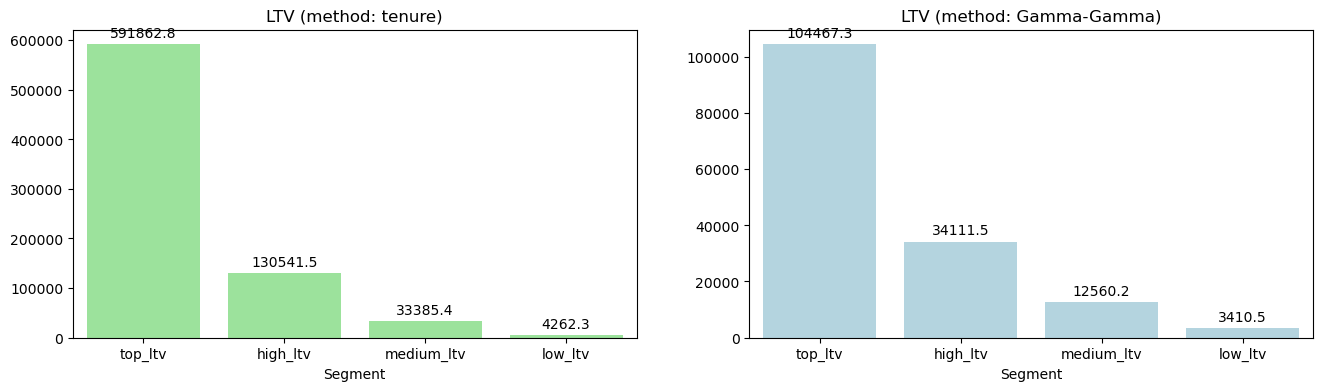

In [63]:
# Plotting the segments
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

ax1 = sns.barplot(data=ltv_total.sort_values('ltv_full_tenure', ascending=False), 
                  x='segment_ltv_based_on_tenure', y='ltv_full_tenure', color='lightgreen',
                  ax=axs[0], ci=False)
ax2 = sns.barplot(data=ltv_total.sort_values('ltv_gamma_gamma', ascending=False), 
                  x='segment_ltv_gamma_gamma', y='ltv_gamma_gamma', color='lightblue',
                  ax=axs[1], ci=False)

# Iterating over the bars one-by-one
for ax in [ax1, ax2]:
    for bar in ax.patches:
        ax.annotate(format(bar.get_height(), '.1f'),
                       (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                       ha='center', 
                       va='center', 
                       xytext=(0, 8),
                       textcoords='offset points'
                      )

    ax.set(xlabel='Segment')

ax1.set(title='LTV (method: tenure)', ylabel='')
ax2.set(title='LTV (method: Gamma-Gamma)', ylabel='');


It is clearly seen that **in all segments LTV calculated by multiplying revenue per customer by projected tenure
is much higher than LTV calculated using Gamma-Gamma model**.

I think that **using Gamma-Gamma model is a much better approach, so the values we get using this method are more realistic**.
